# P07 - Bayesian Analysis of ARPAV Time Series on Temperatures and Precipitations

<table style="width:100%">
  <tr>
    <td style="text-align:left; vertical-align:top">
      <strong>Participants:</strong><br>
      Miguel Avilés Moreno<br>
      José Gonzalez Lerma<br>
      Ana Sofía Salcido Gutierrez
    </td>
    <td style="text-align:right; vertical-align:top">
      <img src="logo-unipd.gif" alt="University of Padova Logo" width="120"><br>
      <strong>Advanced Statistics for Physics Analysis</strong><br>
      Academic Year 2024/2025
    </td>
  </tr>
</table>


- **Auronzo di Cadore**
    - **Latitude:** 46°33′33″ N
    - **Longitude:** 12°25′28″ E
    - **Altitude above sea level:** 887 m
- **Porto Tolle**
    - **Latitude:** 44°56′58″ N
    - **Longitude:** 12°19′28″ E
    - **Altitude above sea level:** -22 m
- **Castelfranco Veneto**
    - **Latitude:** 45°40′00″ N
    - **Longitude:** 11°55′00″ E
    - **Altitude above sea level:** 46 m

## Libraries

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(lubridate))
suppressPackageStartupMessages(library(rstan))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(bayesplot))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(forecast))
suppressPackageStartupMessages(library(readr))
suppressPackageStartupMessages(library(loo))

## Data Extraction

File for each station: 
- **Auronzo di Cadore**
- **Porto Tolle**
- **Castelfranco Veneto**

Each file contains 3 blocks:
- block with **min temperatures**
- block with **mean (medium) temperatures**
- block with **max temperatures**

**Example:** Auronzo Station (min temperature block)
<div style="text-align: center;">
  <img src="Blocks.png" alt="Blocks Diagram" style="width: 40%;">
</div>


`extract_block <- function(start_line, type_label)`: (internal function) 

- Find the header: 2 lines after the "media delle minime" : `Anno;GEN;FEB;MAR;APR;MAG;GIU;LUG;AGO;SET;OTT;NOV;DIC;Medio`
- Data block continues until the next occurrence of the word "Stazione"
- Structure: one row per year, **12 columns for months** $\rightarrow$ **1 row per year-month**, adding new column for temperature type

`process_station_file <- function(file_path)`: reads the temperature data of one station and outputs a dataframe

- Find the line number where each block starts
- Apply `extract_block` for each block $\rightarrow$ 3 dataframes with identical structure
- We merge 3 blocks into 1 dataframe $\rightarrow$ filter out NA $\rightarrow$ select years between 1993 and 2021.

In [3]:
process_station_file <- function(file_path) {
  lines <- readLines(file_path)

  extract_block <- function(start_line, type_label) {
    header <- read.csv2(text = lines[start_line + 2], nrows = 1)
    data_start <- start_line + 3
    next_stazione <- grep("Stazione", lines[(data_start):length(lines)])
    data_end <- if (length(next_stazione) == 0) length(lines) else data_start + next_stazione[1] - 2
    block <- read.csv2(text = paste(lines[data_start:data_end], collapse = "\n"))
    block_long <- block %>%
      pivot_longer(-Anno, names_to = "Month", values_to = "Temperature") %>%
      mutate(Type = type_label)
    return(block_long)
  }
  
  pos_min <- grep("media delle minime", lines)
  pos_medium <- grep("media delle medie", lines)
  pos_max <- grep("media delle massime", lines)
  
  df_all <- bind_rows(
    extract_block(pos_min, "min"),
    extract_block(pos_medium, "medium"),
    extract_block(pos_max, "max")
  ) %>%
    rename(Year = Anno) %>%
    mutate(
      Month = factor(Month,
        levels = c("GEN", "FEB", "MAR", "APR", "MAG", "GIU", "LUG", "AGO", "SET", "OTT", "NOV", "DIC"),
        labels = c("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")
      )
    ) %>%
    filter(complete.cases(.), Year >= 1993, Year <= 2021) %>%
    arrange(Year, Month, Type)
  
  return(df_all)
}

## Dataframe Creation

Create a dataframe reading with the `process_station_file()` function each file for the three selected stations

In [7]:
files <- c("Castelfranco_Temperature.csv", "Porto_Tolle_Temperature.csv", "Auronzo_Temperature.csv")
station_names <- c("Castelfranco", "Porto_Tolle", "Auronzo")

station_dfs <- setNames(vector("list", length(files)), station_names)

for (i in seq_along(files)) {
  station_dfs[[i]] <- process_station_file(files[i])
}

Display of the structure of the dataframe

In [9]:
head(station_dfs$Castelfranco)
head(station_dfs$Porto_Tolle)
head(station_dfs$Auronzo)

Year,Month,Temperature,Type
<chr>,<fct>,<chr>,<chr>
1994,Jan,9.6,max
1994,Jan,4.1,medium
1994,Jan,-0.5,min
1994,Feb,8.5,max
1994,Feb,3.3,medium
1994,Feb,-1.4,min


Year,Month,Temperature,Type
<chr>,<fct>,<chr>,<chr>
1994,Jan,8.6,max
1994,Jan,4.6,medium
1994,Jan,0.8,min
1994,Feb,8.5,max
1994,Feb,4.7,medium
1994,Feb,1,min


Year,Month,Temperature,Type
<chr>,<fct>,<chr>,<chr>
1994,Jan,3.7,max
1994,Jan,-2.2,medium
1994,Jan,-6.1,min
1994,Feb,5.1,max
1994,Feb,-1.6,medium
1994,Feb,-6,min


**Proof**: let see that there aren't missing values and the dataframe has been correctly created

In [12]:
for (station_name in names(station_dfs)) {
  na_rows <- station_dfs[[station_name]] %>%
    filter(if_any(everything(), is.na))  
  if (nrow(na_rows) > 0) {
    cat("Missing values found in station:", station_name, "\n")
    print(na_rows)
  } else {
    cat("No missing values in station:", station_name, "\n")
  }
}

No missing values in station: Castelfranco 
No missing values in station: Porto_Tolle 
No missing values in station: Auronzo 


**Part 0: 
Study the evolution over time of the min, max and average temperatures computed over one month**.

- Loop for the three stations: `'"Castelfranco", "Porto_Tolle", "Auronzo"`
- Create a column `Date` combining `Year` and `Month` $\rightarrow$ giving cronological order for x-axis
- Plot `Temperature` vs `Date` using `Type` as color argument

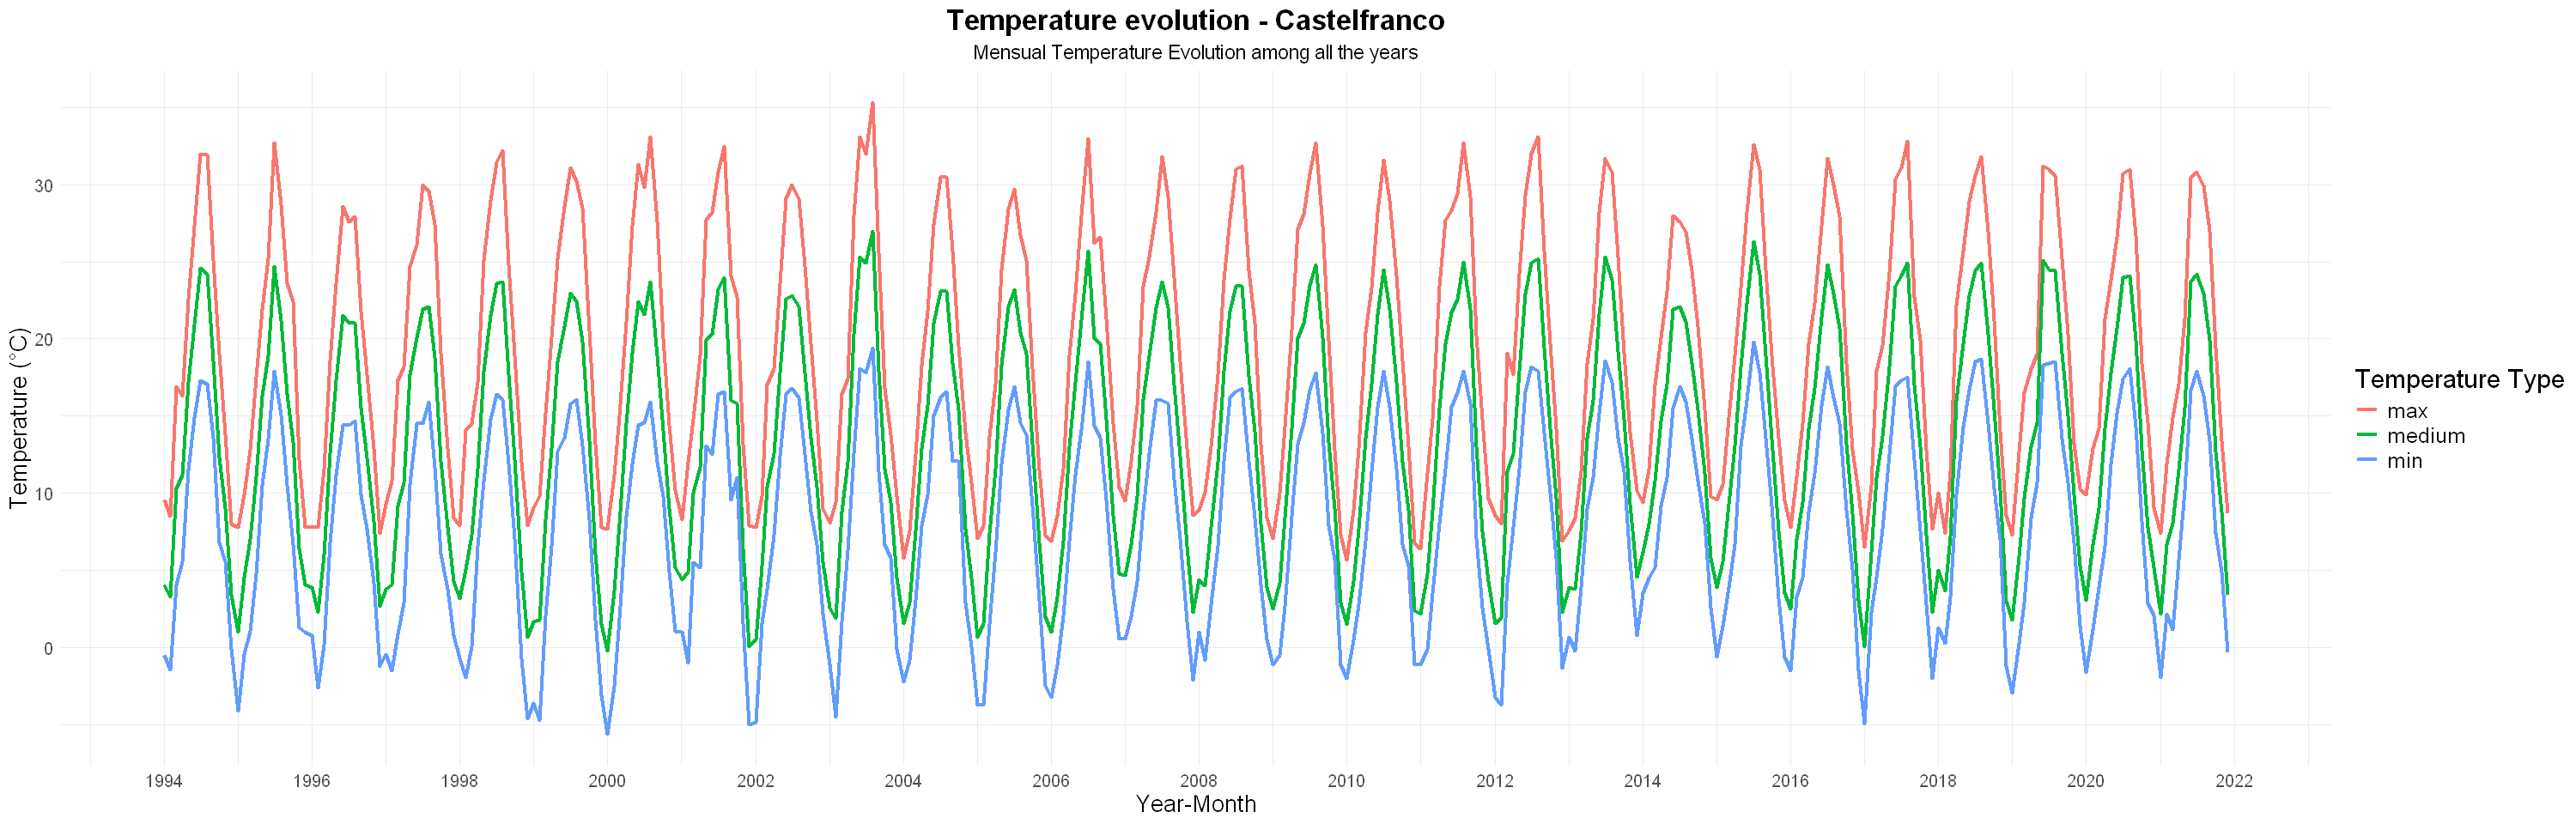

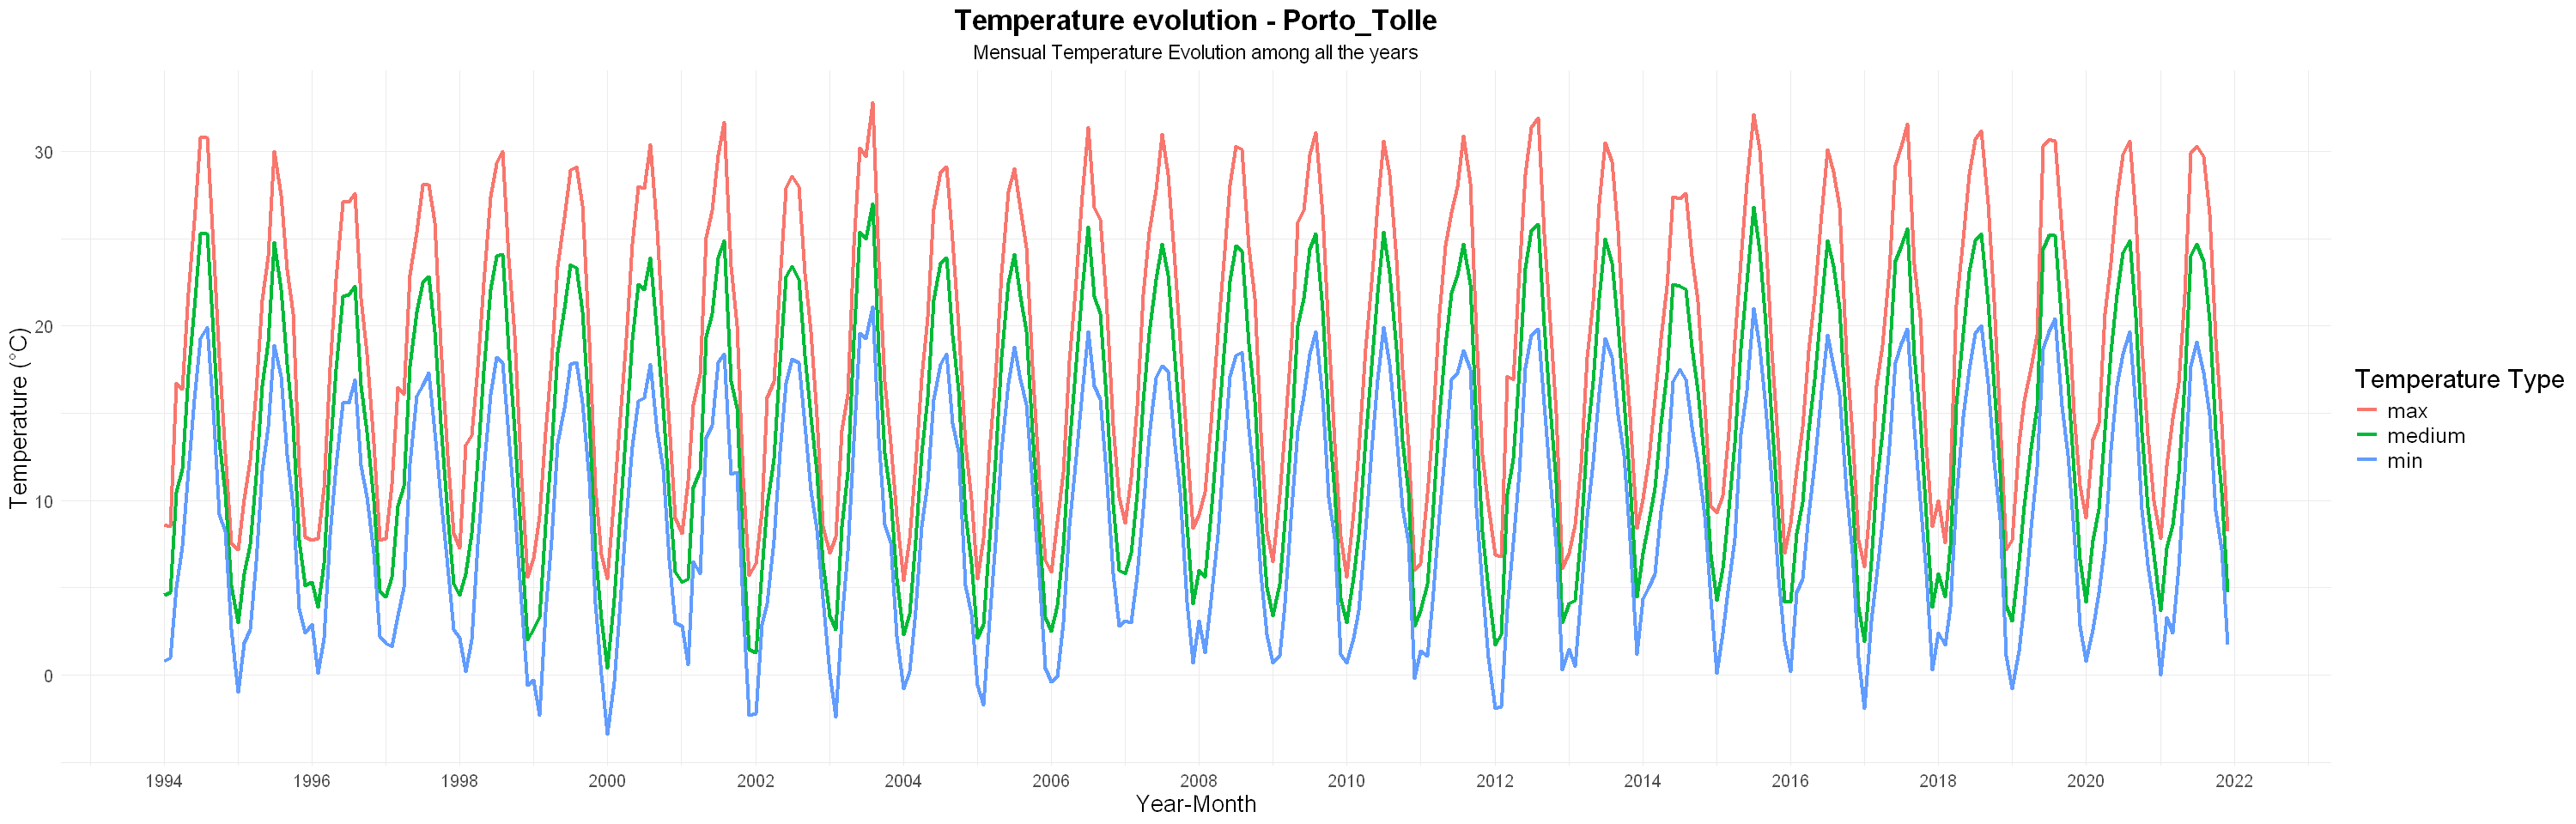

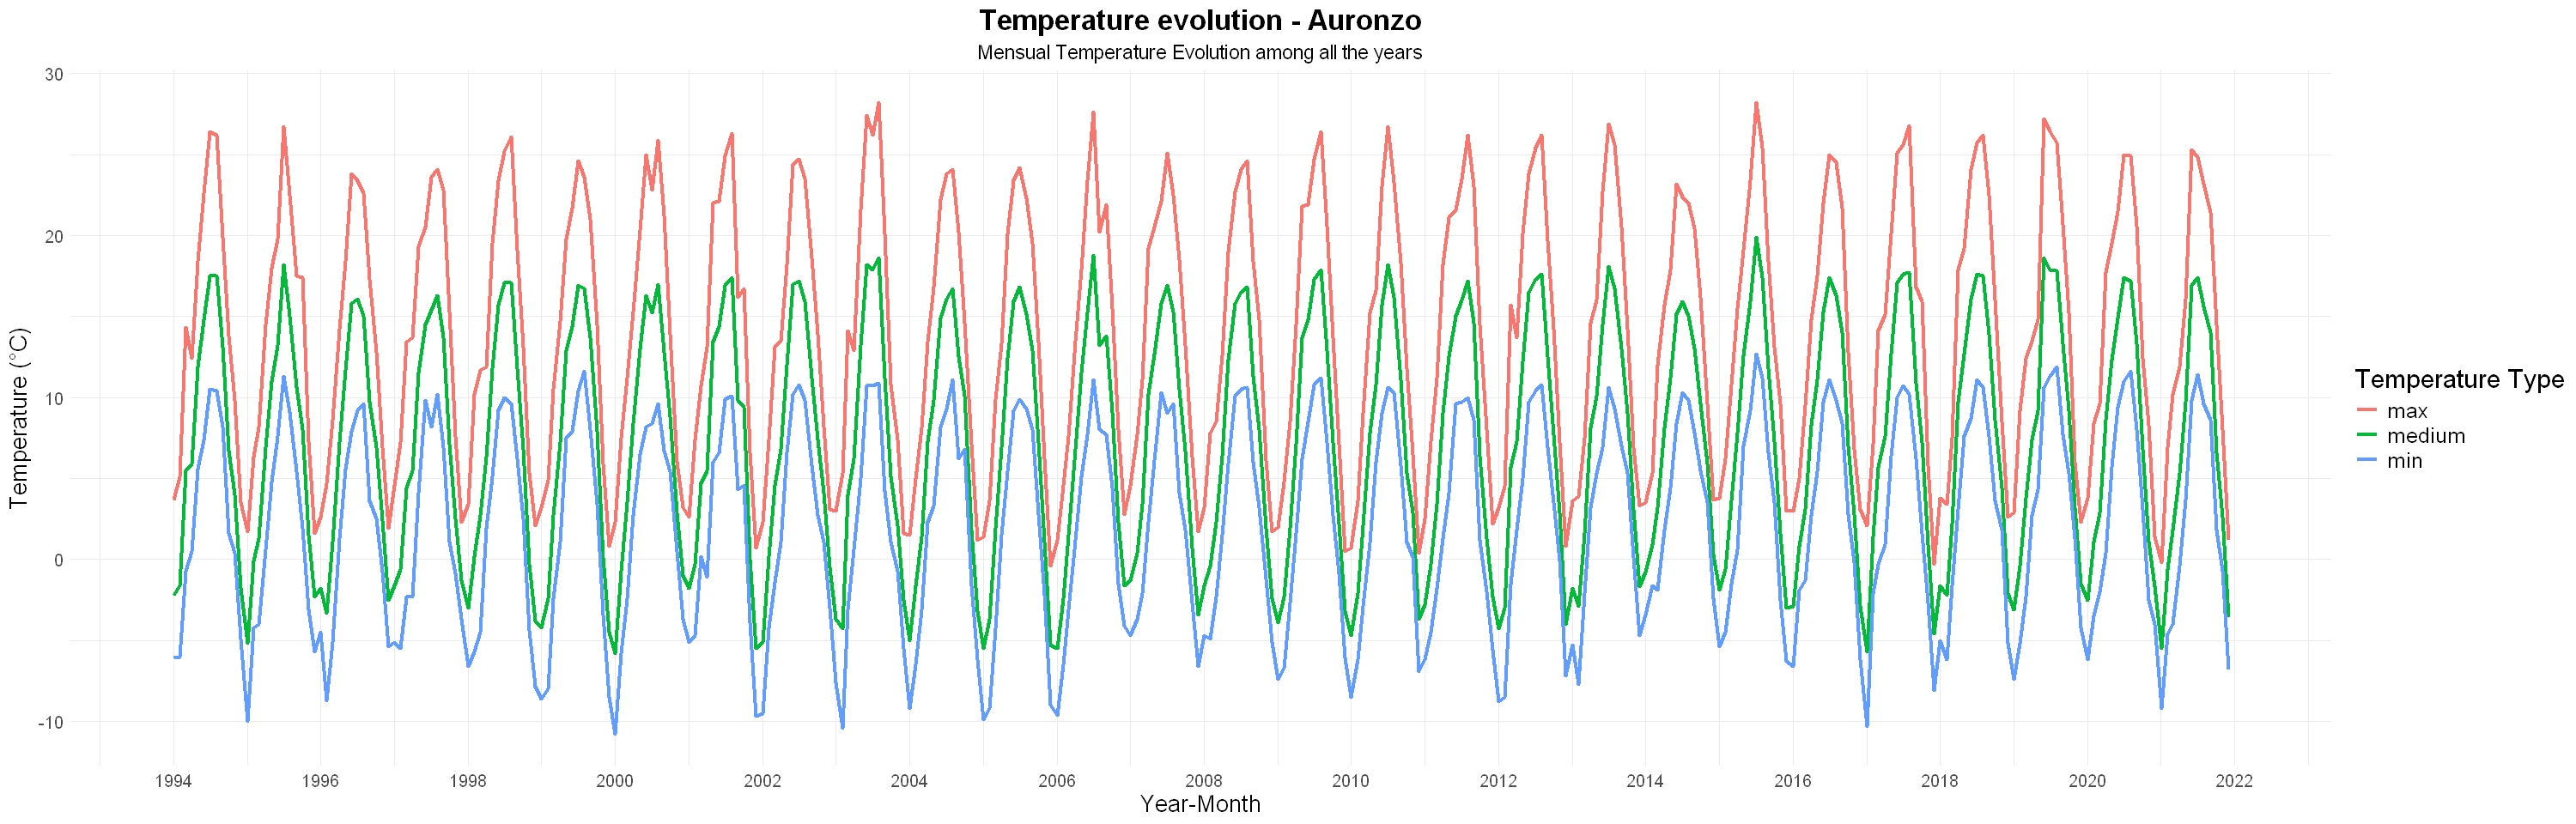

In [15]:
options(repr.plot.width=25, repr.plot.height=8)
for (station_name in names(station_dfs)) {
    df <- station_dfs[[station_name]]
    df$Temperature <- as.numeric(df$Temperature)
    df <- df |> mutate(Date = ymd(paste0(Year, '-' , as.numeric(Month), '-01' )))

    p <- ggplot(df, aes(x = Date, y = Temperature, color = Type)) +
        geom_line(linewidth = 1.25) +
        labs(title = paste("Temperature evolution -", station_name), subtitle = "Mensual Temperature Evolution among all the years",
        x = "Year-Month", y = "Temperature (°C)", color = "Temperature Type") +
        theme_minimal() + 
        scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
        theme_minimal() +
        theme(
          plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
          plot.subtitle = element_text(size = 14, hjust = 0.5),
          axis.title = element_text(size = 16),
          axis.text = element_text(size = 12),
          legend.title = element_text(size = 18),
          legend.text = element_text(size = 15)
        )
  print(p)
}

**🌡️ Temperature Trends Across Stations**

- **Castelfranco** and **Auronzo di Cadore** exhibit similar temperature behaviors over the years as both are located in the northern part of Veneto and share a more mountainous or inland terrain. These stations typically experience:
  - **Warmer summers** due to continental influence and elevation.
  - **Colder winters** with more pronounced seasonal variation.

- In contrast, **Porto Tolle**, situated in the southern coastal area of Veneto near the Po River Delta, shows a markedly different trend:
  - **Moderate temperatures year-round**, with less extreme seasonal shifts.
  - This is characteristic of **coastal climates**.

<div style="text-align: center; margin-top: 20px;">
  <img src="Stations.png" alt="Map of Station Locations" style="width: 25%;">
  <p style="font-size: 90%; color: black;"><em>Figure 1: Geographic locations of the three stations in Veneto.</em></p>
</div>


**Part 1: Analysis of the evolution of the annual average of the min, max and daily average temperature over time (1993 - 2021).**

- **Study the trend of the annual averages and compare them with a constant value or a rising trend (for instance linear or quadratic)**

- Loop for the three stations: `"Castelfranco", "Porto_Tolle", "Auronzo"`
- Use of `group_by` and `summarise`
- For each `Year` and `Type` compute the `Anual_Temperature` $\rightarrow$ points
- Compute the `mean_temp` for each type along all years $\rightarrow$ horizontal dashed lines
- Compare the tendency with linear trend $\rightarrow$ horizontal lines

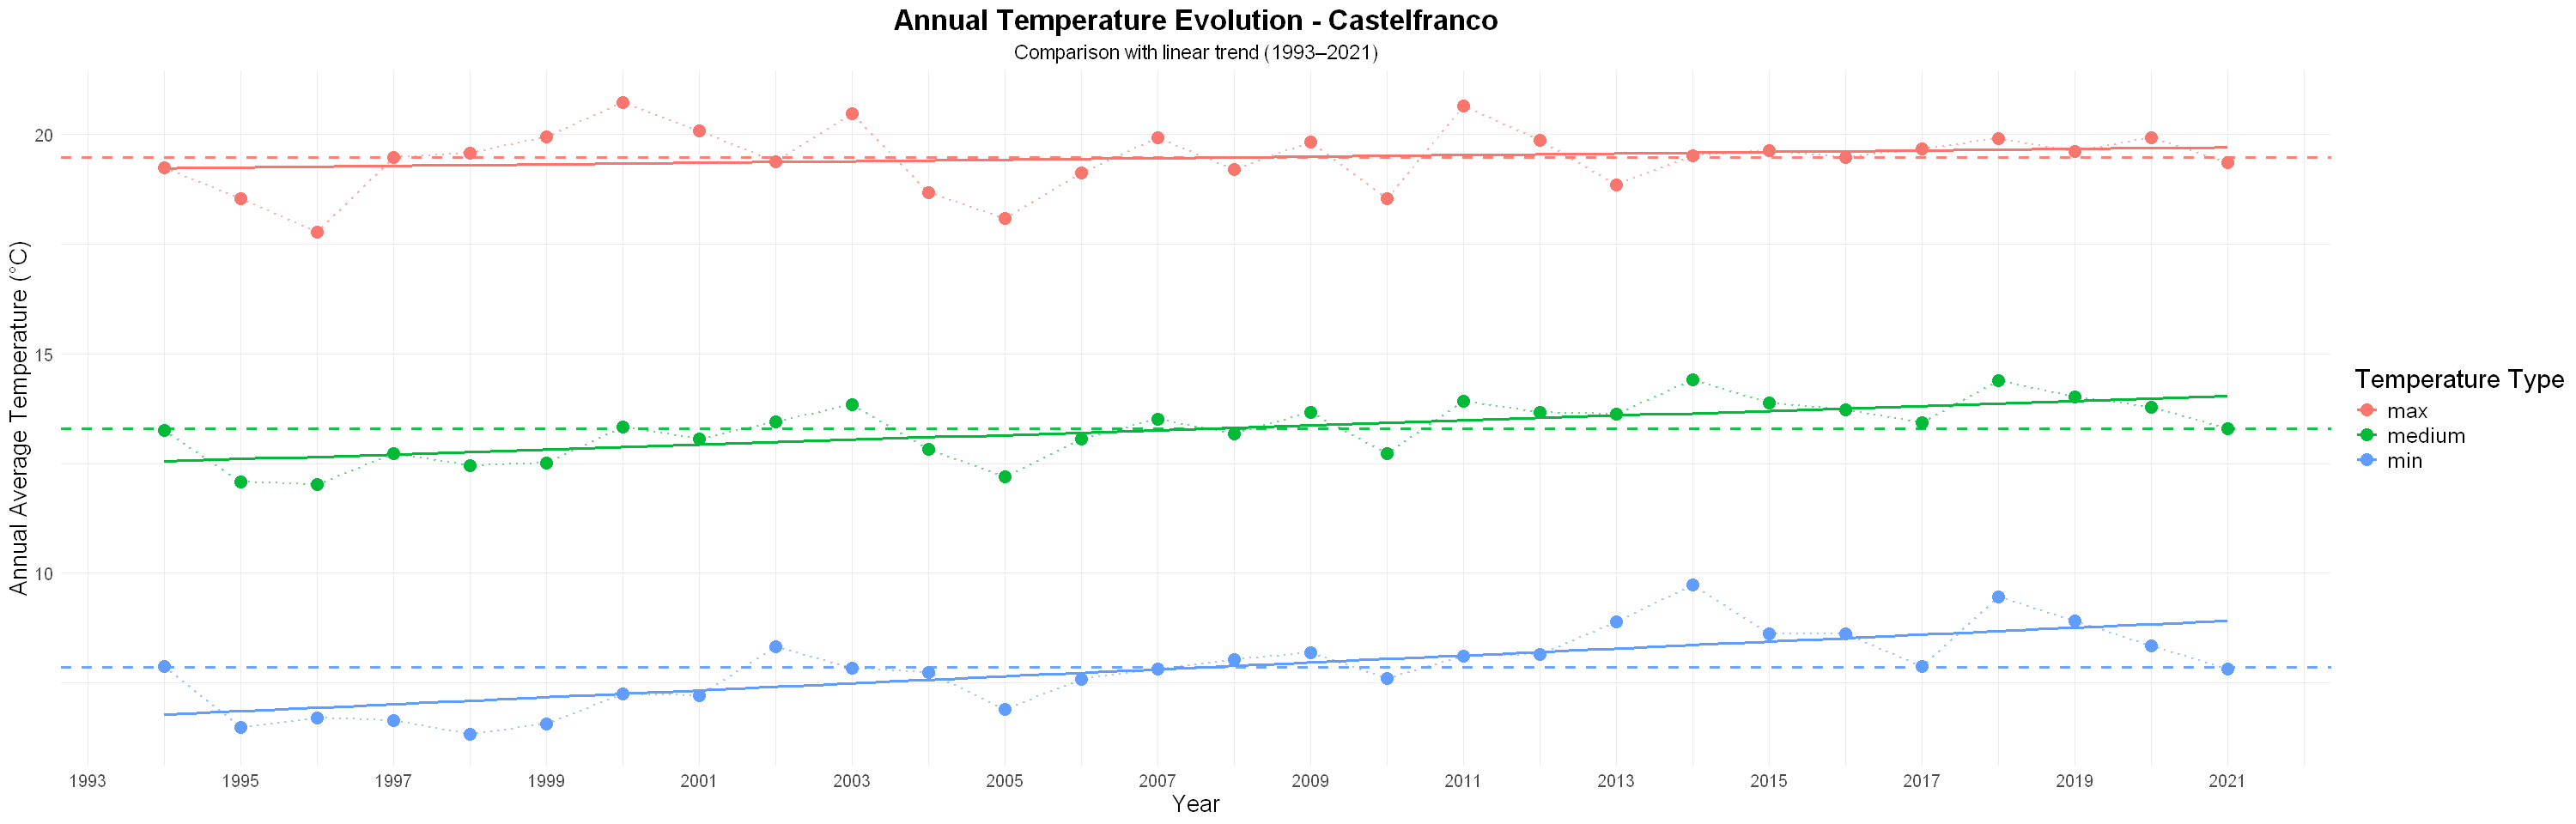

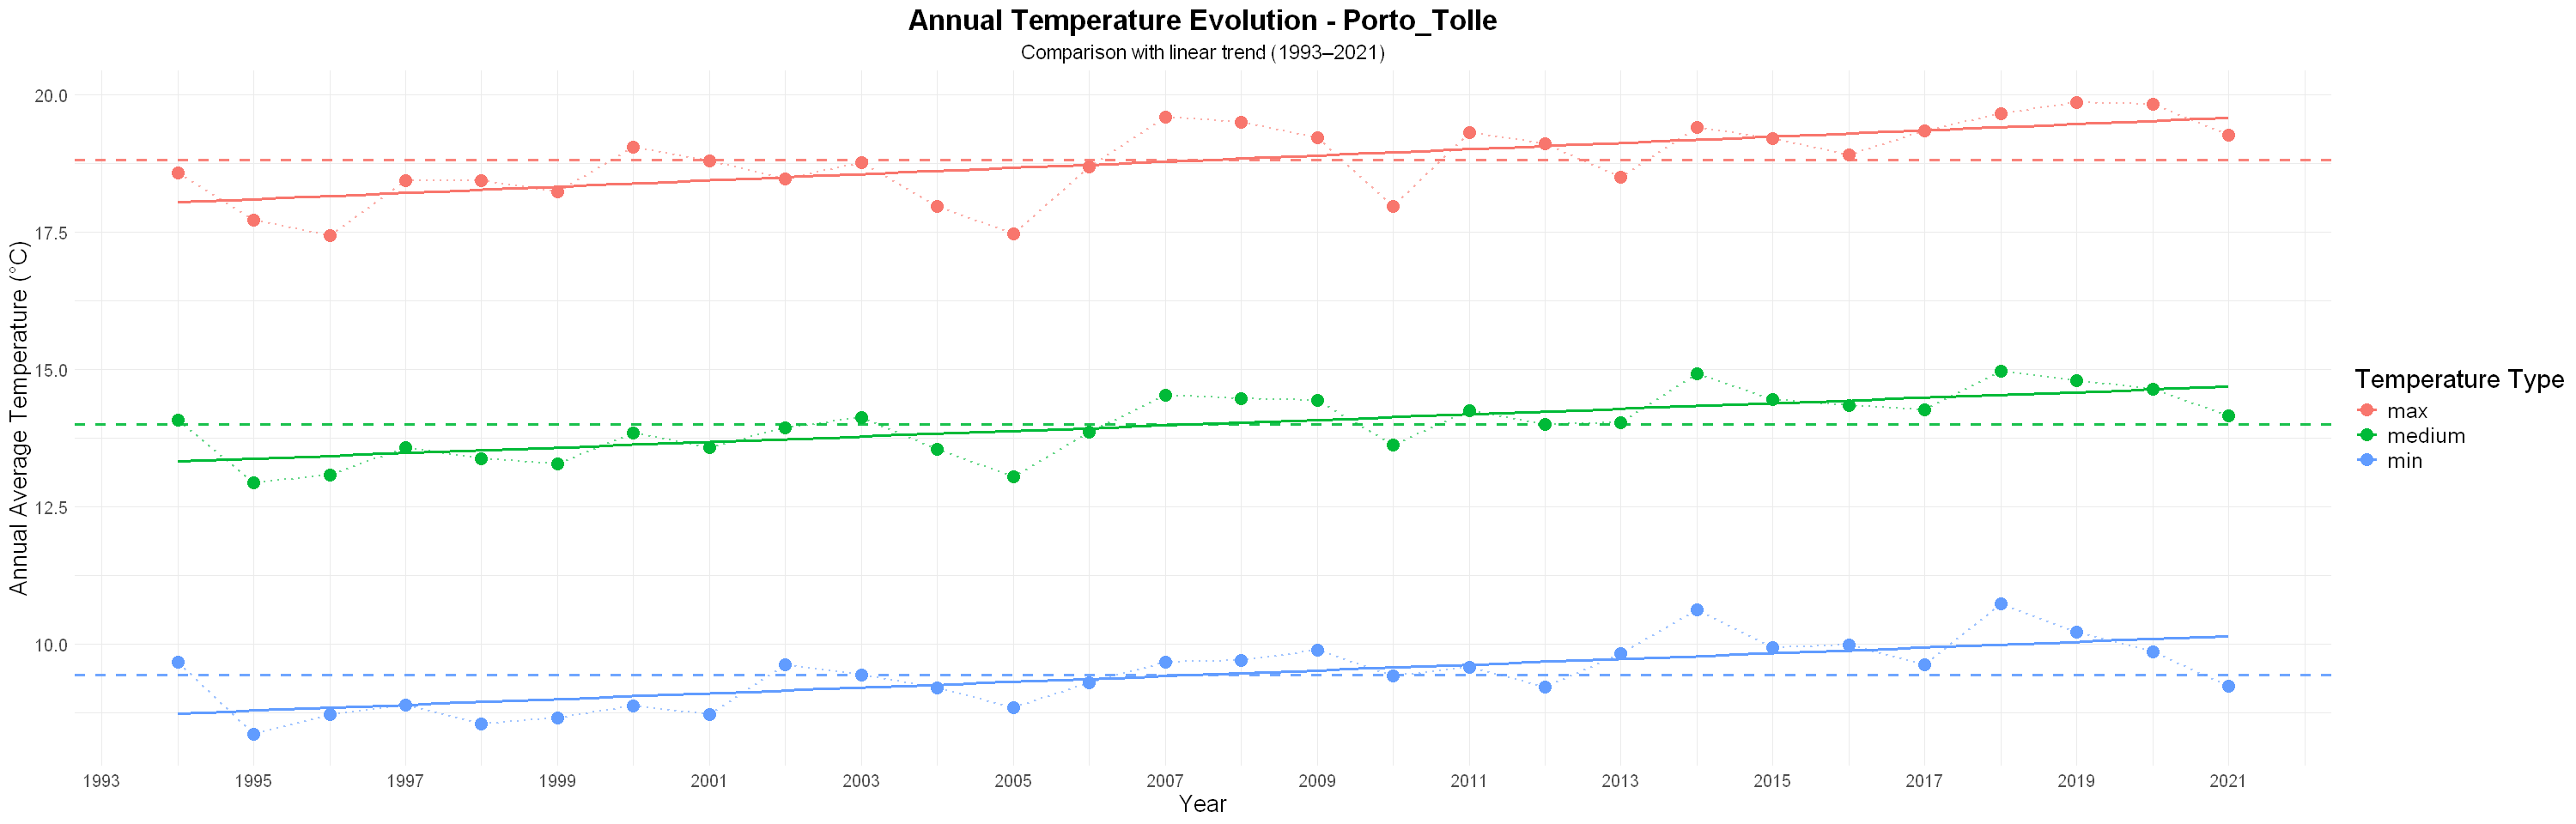

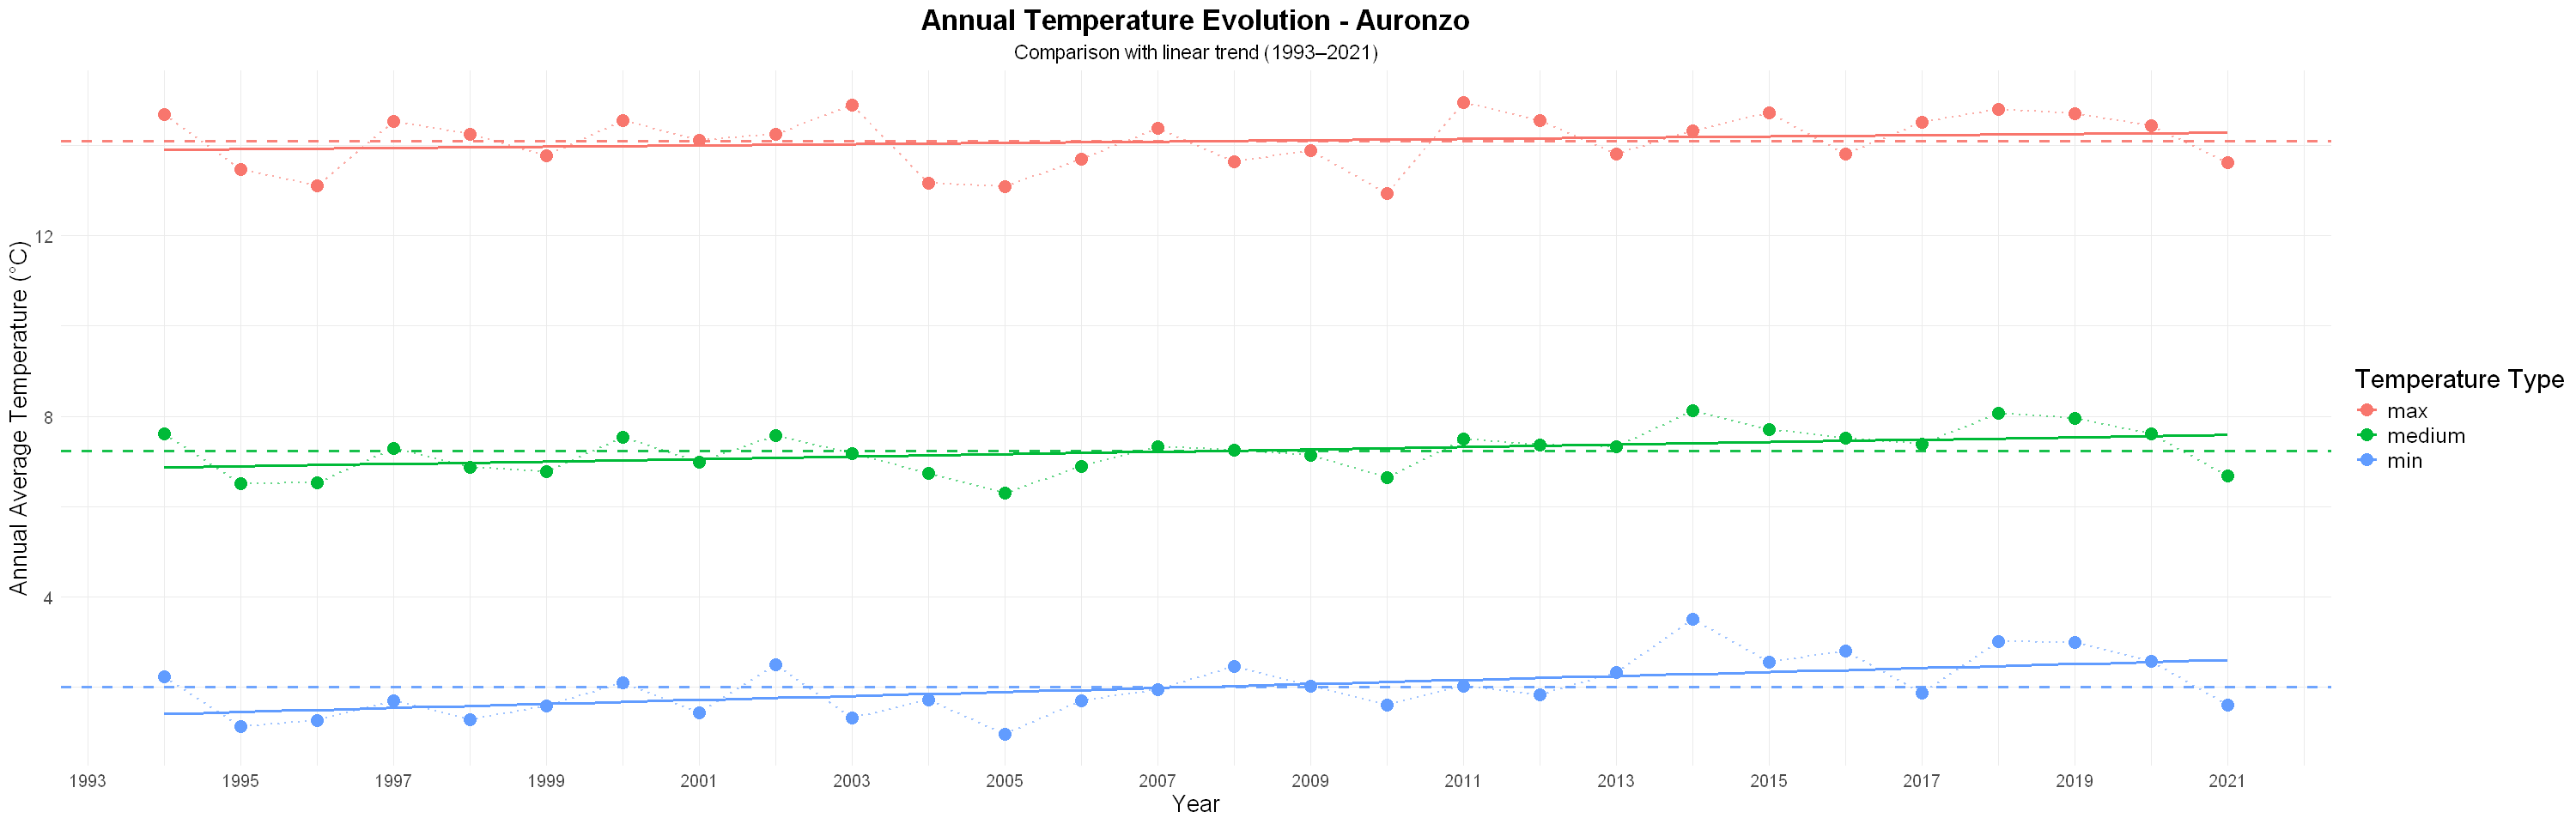

In [17]:
for (station_name in names(station_dfs)) {
  df <- station_dfs[[station_name]]
  df$Temperature <- as.numeric(df$Temperature)
  df <- df |>
    group_by(Year, Type) |>
    summarise(Anual_Temperature = mean(Temperature), .groups = 'drop')
  
  df$Year <- as.numeric(df$Year)
  
  means_df <- df |>
    group_by(Type) |>
    summarise(mean_temp = mean(Anual_Temperature), .groups = "drop")
  
  p <- ggplot(df, aes(x = Year, y = Anual_Temperature, color = Type)) +
    geom_point(size = 4) +
    geom_line(aes(group = Type), linewidth = 0.75, linetype = "dotted", alpha = 0.6) +
    geom_hline(data = means_df,
               aes(yintercept = mean_temp, color = Type),
               linetype = "dashed", linewidth = 1, alpha = 0.9) +
    geom_smooth(method = "lm", se = FALSE, linewidth = 1) +
    labs(
      title = paste("Annual Temperature Evolution -", station_name),
      subtitle = "Comparison with linear trend (1993–2021)",
      x = "Year",
      y = "Annual Average Temperature (°C)",
      color = "Temperature Type"
    ) +
    scale_x_continuous(breaks = seq(1993, 2021, by = 2)) +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 14, hjust = 0.5),
      axis.title = element_text(size = 16),
      axis.text = element_text(size = 12),
      legend.title = element_text(size = 18),
      legend.text = element_text(size = 15)
    )
  
  suppressMessages(print(p))
}

**📈 Long-Term Temperature Trend**

The graph reveals a **gradual increase in annual temperatures**n  ithe three statio21. All three temperature categories—**maximum**, **medium**, and **minimum**—exhibit a **slightly upward linear trend**, indicating a **moderate but consistent warming** over the year.


- **Perform an analysis using a Bayesian linear regression with JAGS or STAN**

**Bayesian Linear Model**

The annual average temperature $T$ is assumed to follow a linear relationship with time:

$$
T_t = \beta_0 + \beta_1 \cdot t_t + \varepsilon_t, \quad \varepsilon_t \sim \text{Normal}(0, \sigma)
$$

**Parameter Priors**
- $\beta_0 \sim \text{Uniform}(-5,\ 20)$  
  Intercept term using an uniform distribution within a wide range, because the intercept will vary depending of the type of measurement: min, medium or max.

- $\beta_1 \sim \text{Uniform}(0,\ 0.5)$  
  Slope parameter restricted to moderate positive based on the plot of annual tendency (slight increase).

- $\sigma \sim \text{Normal}(0,\ 1.5)$  
  Standard deviation of the residuals, constrained to positive values.


**Bayesian Constant Model (No Trend)**

Here, the annual temperature is assumed to fluctuate around a constant mean $\mu$:

$$
T_t = \mu + \varepsilon_t, \quad \varepsilon_t \sim \text{Normal}(0, \sigma)
$$

**Parameter Priors**
- $\mu \sim \text{Uniform}(-5,\ 20)$  
  A flat prior over the possible temperature levels.

- $\sigma \sim \text{Normal}(0,\ 1.5)$  
  Captures residual variability around the constant level.

**Bayesian inference via STAN to estimate the parameters**

In [19]:
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

In [21]:
linear_model_code <- '
data {
  int<lower=0> N;
  vector[N] t;
  vector[N] T;
}
parameters {
  real<lower=-5, upper=20> beta_0;         // intercept
  real<lower=0, upper=0.5> beta_1;         // slope
  real<lower=0> sigma;                     // std deviation
}
model {
  sigma ~ normal(0, 1.5);                  // prior on sigma
  T ~ normal(beta_0 + beta_1 * t, sigma);  // likelihood
}'
writeLines(linear_model_code, "linear_model.stan")



constant_model_code <- '
data {
  int<lower=0> N;
  vector[N] T;
}
parameters {
  real<lower=-5, upper=20> mu;             // mean value
  real<lower=0> sigma;                     // std deviation
}
model {
  sigma ~ normal(0, 1.5);                  // prior on sigma
  T ~ normal(mu, sigma);                   // likelihood
}'
writeLines(constant_model_code, "constant_model.stan")


`run_bayesian_regression`: Fits either a linear trend or a constant mean to the annual average temperatures for a given station and measurement type.

- We can specify the station, type of temperature and regression type
- Filter by the temperature `Type`
- Calculate `Annual_Temperature`
- Data:
  - $N$: number of points
  - $t$: vector of centered years
  - $T$: annual temperatures
- Parameters to estimate:
  - Linear regression: `"beta_0", "beta_1", "sigma"`
  - Constant regression: `"mu", "sigma"`
- Run Bayesian Analysis with $5000$ iterations and $4$ chains
- Summary of parameters: posterior means, std devs, quantiles
- Display the fit: using the mean value of the parameters
- Using the R library `bayesplot` display **Trace Plots** (convergence of chains) and **Posterior Distribution for the parameters**

In [25]:
run_bayesian_regression <- function(station_dfs, station_name, type_selected, model_type = c("linear", "constant")) {
  model_type <- match.arg(model_type)
  
  df <- station_dfs[[station_name]] |>
    filter(Type == type_selected) |>
    mutate(
      Temperature = as.numeric(Temperature),
      Year = as.numeric(Year)
    ) |>
    group_by(Year) |>
    summarise(Annual_Temperature = mean(Temperature), .groups = "drop")
  
  df$T <- df$Annual_Temperature
  df$Year <- as.numeric(df$Year)
  
  if (model_type == "linear") {
    df$t <- df$Year - mean(df$Year)
    
    stan_data <- list(
      N = nrow(df),
      t = df$t,
      T = df$T
    )
    
    model_file <- "linear_model.stan"
    params_to_plot <- c("beta_0", "beta_1", "sigma")
    
  } else {
    stan_data <- list(
      N = nrow(df),
      T = df$T
    )
    
    model_file <- "constant_model.stan"
    params_to_plot <- c("mu", "sigma")
  }
  
  fit <- stan(
    file = model_file,
    data = stan_data,
    iter = 5000,
    chains = 4,
    seed = 123,
    refresh = 0
  )  
  print(fit, pars = params_to_plot)
  
  posterior <- extract(fit)
  
  if (model_type == "linear") {
    df$fit_mean <- mean(posterior$beta_0) + mean(posterior$beta_1) * df$t
    
    p_fit <- ggplot(df, aes(x = Year, y = T)) +
      geom_point(size = 3, color = "darkblue") +
      geom_line(aes(y = fit_mean), color = "red", linewidth = 1.2) +
      labs(
        title = paste("Bayesian Linear Fit -", station_name),
        subtitle = paste("Temperature Type:", type_selected),
        x = "Year", y = "Annual Avg Temperature (°C)"
      ) +
      theme_minimal()
    
  } else {
    mu_mean <- mean(posterior$mu)
    
    p_fit <- ggplot(df, aes(x = Year, y = T)) +
      geom_point(size = 3, color = "darkgreen") +
      geom_hline(yintercept = mu_mean, color = "red", linewidth = 1.2) +
      labs(
        title = paste("Bayesian Constant Fit -", station_name),
        subtitle = paste("Temperature Type:", type_selected),
        x = "Year", y = "Annual Avg Temperature (°C)"
      ) +
      theme_minimal()
  }
  
  print(p_fit)

  mcmc_array <- as.array(fit)
  p_trace <- mcmc_trace(mcmc_array, pars = params_to_plot)
  p_dens  <- mcmc_dens(mcmc_array, pars = params_to_plot)
  grid.arrange(p_trace, p_dens, ncol = 1)
  return(invisible(fit))
}

Inference for Stan model: anon_model.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

        mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
beta_0 18.81       0 0.10 18.60 18.74 18.81 18.88 19.01  7270    1
beta_1  0.06       0 0.01  0.03  0.05  0.06  0.07  0.08  6986    1
sigma   0.53       0 0.08  0.41  0.48  0.53  0.58  0.71  6778    1

Samples were drawn using NUTS(diag_e) at Wed Jul  2 14:10:20 2025.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


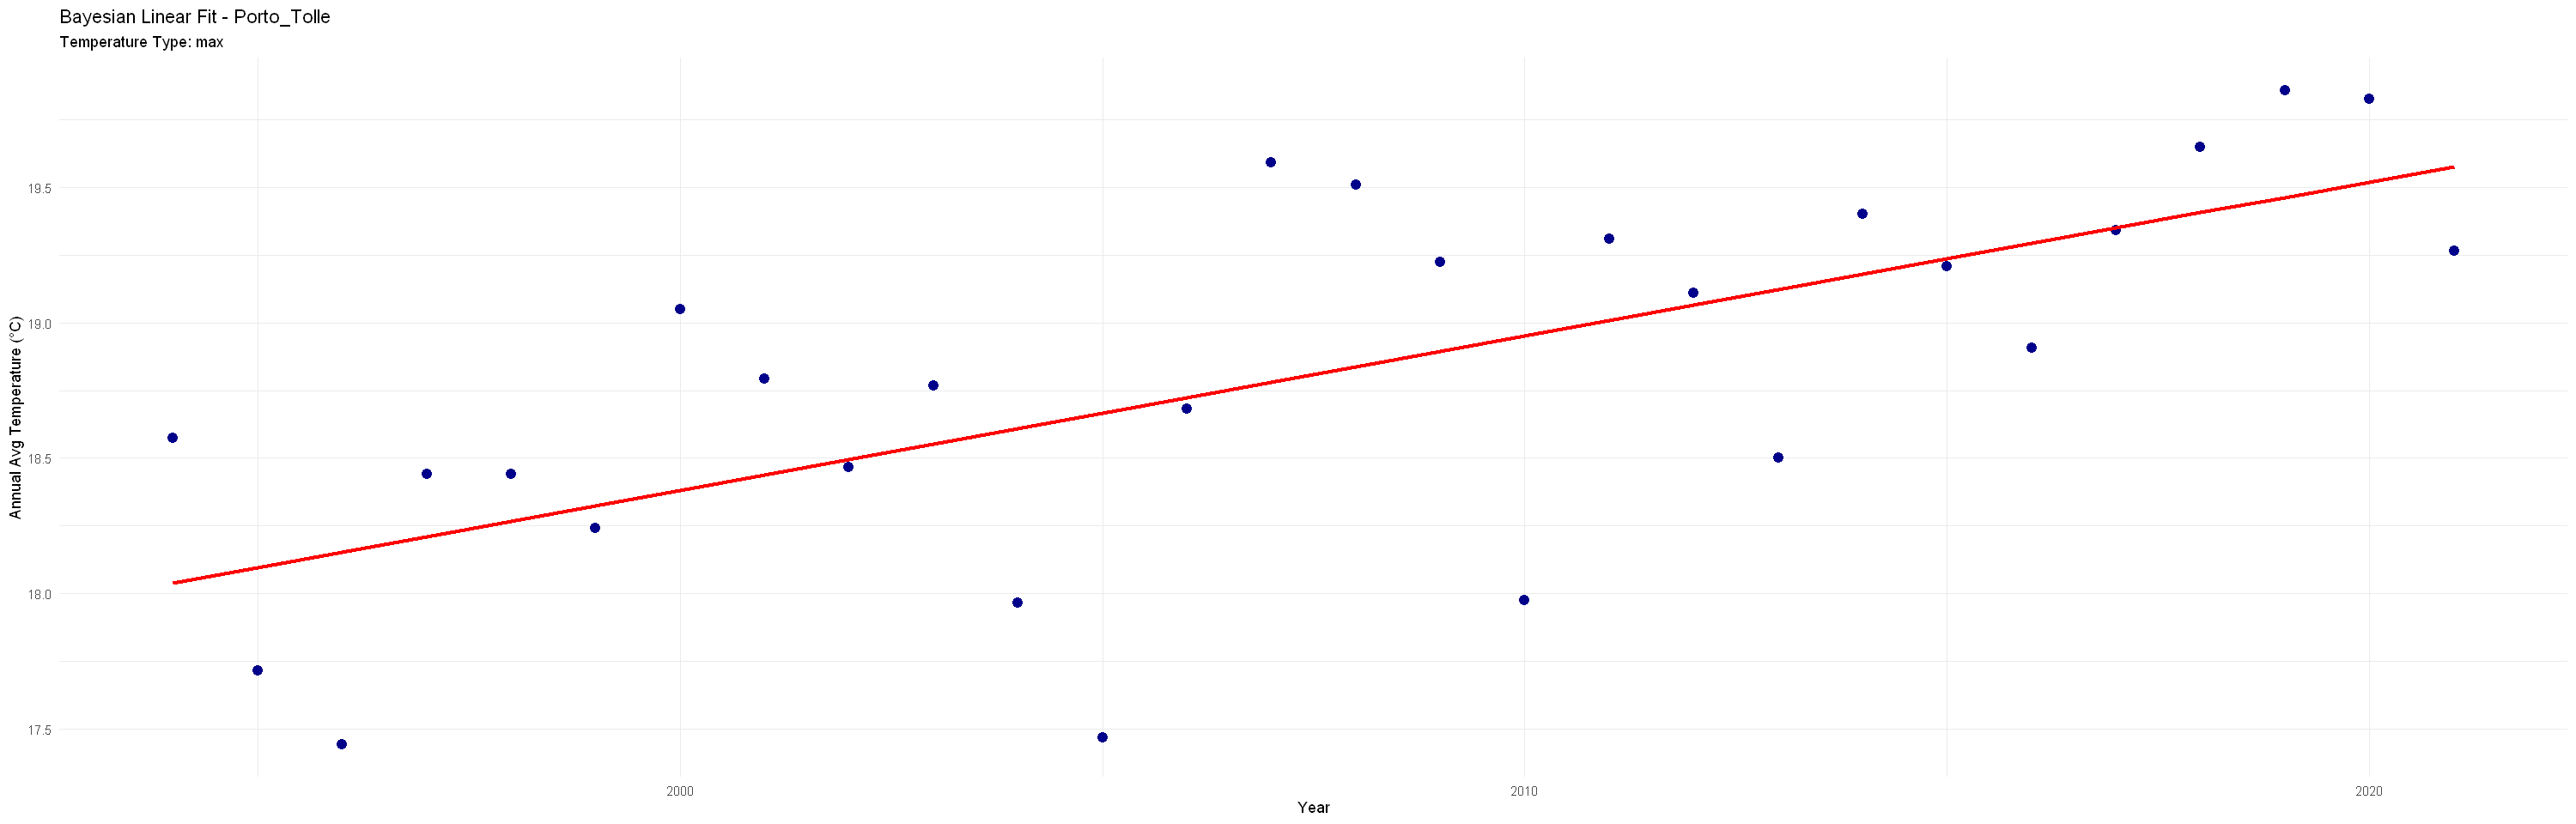

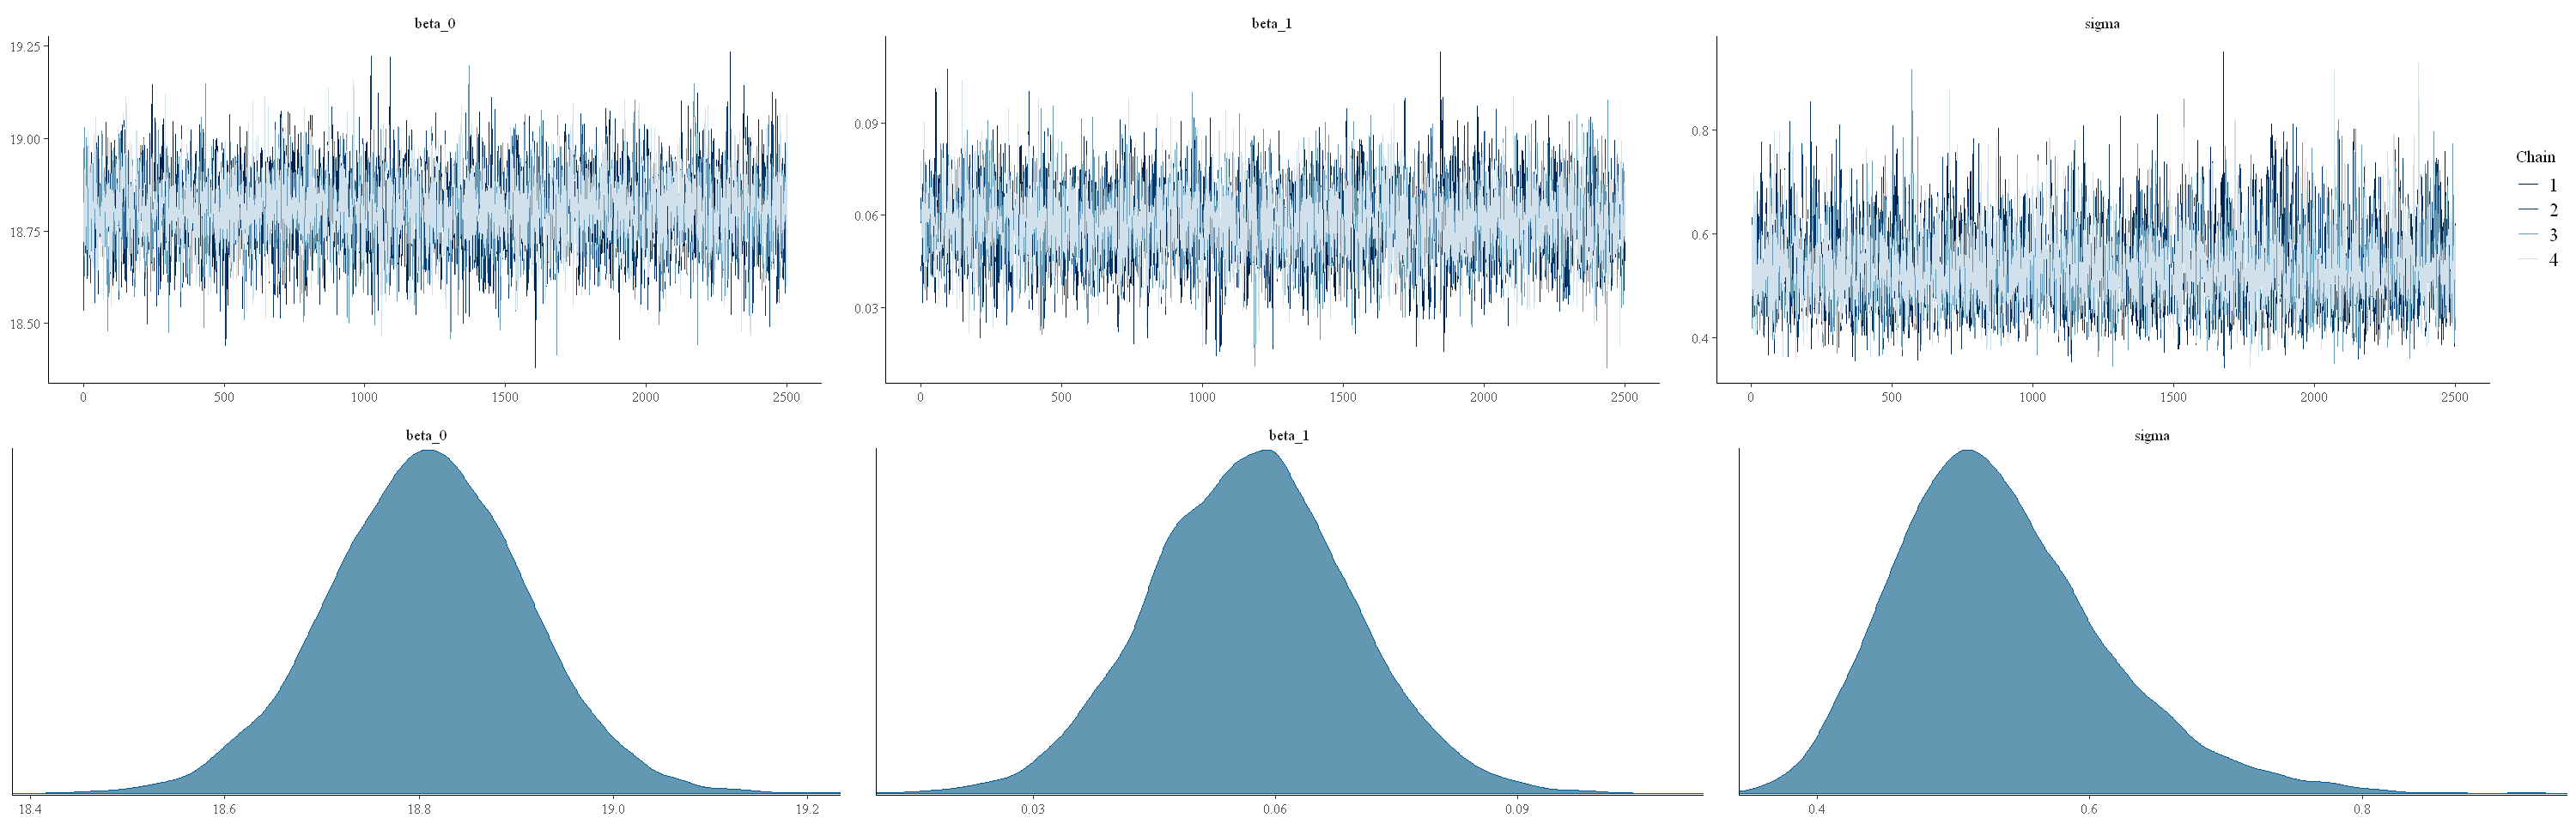

In [27]:
fit_lin <- run_bayesian_regression(station_dfs, "Porto_Tolle", "max", model_type = "linear")

- **Perform the same analysis using a constant regression**

Inference for Stan model: anon_model.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

       mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
mu    18.81       0 0.14 18.54 18.72 18.81 18.90 19.08  5960    1
sigma  0.71       0 0.10  0.55  0.64  0.70  0.77  0.94  6513    1

Samples were drawn using NUTS(diag_e) at Wed Jul  2 14:11:47 2025.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


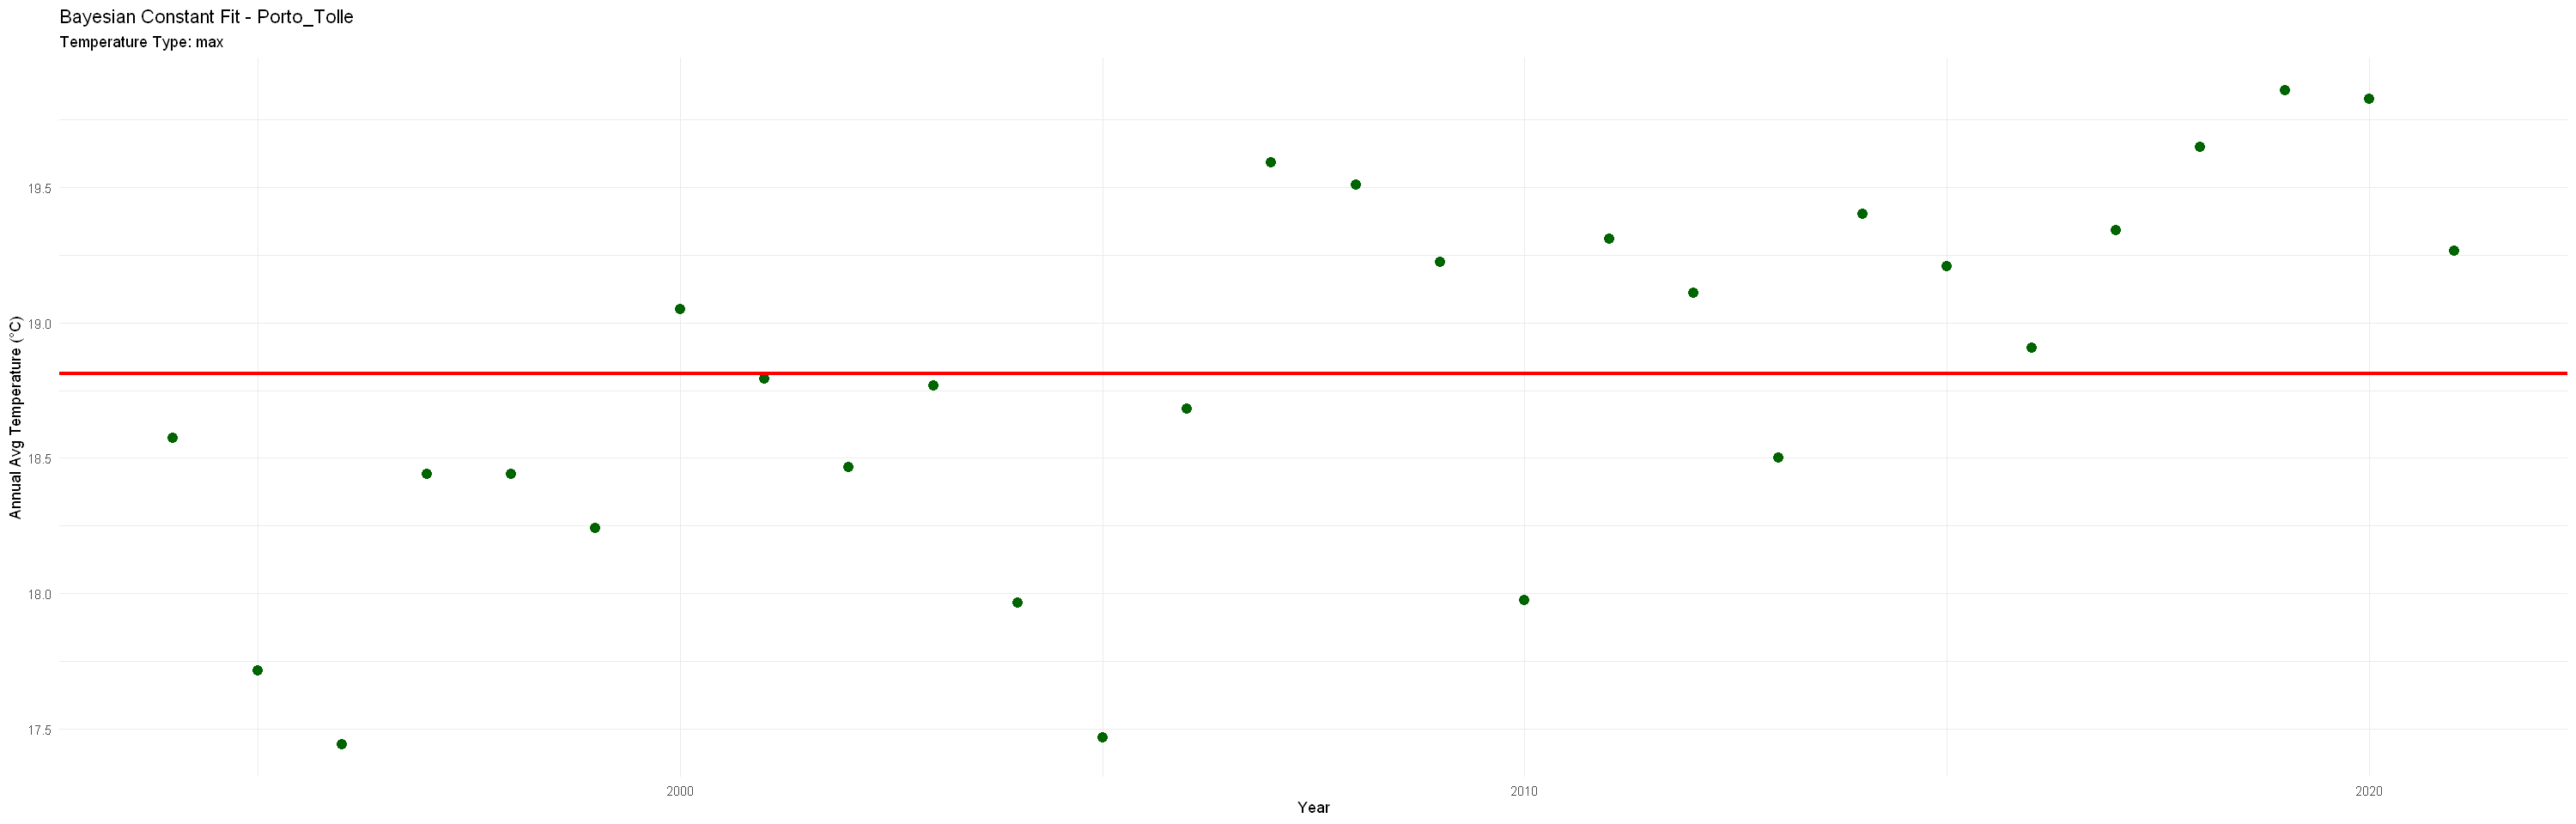

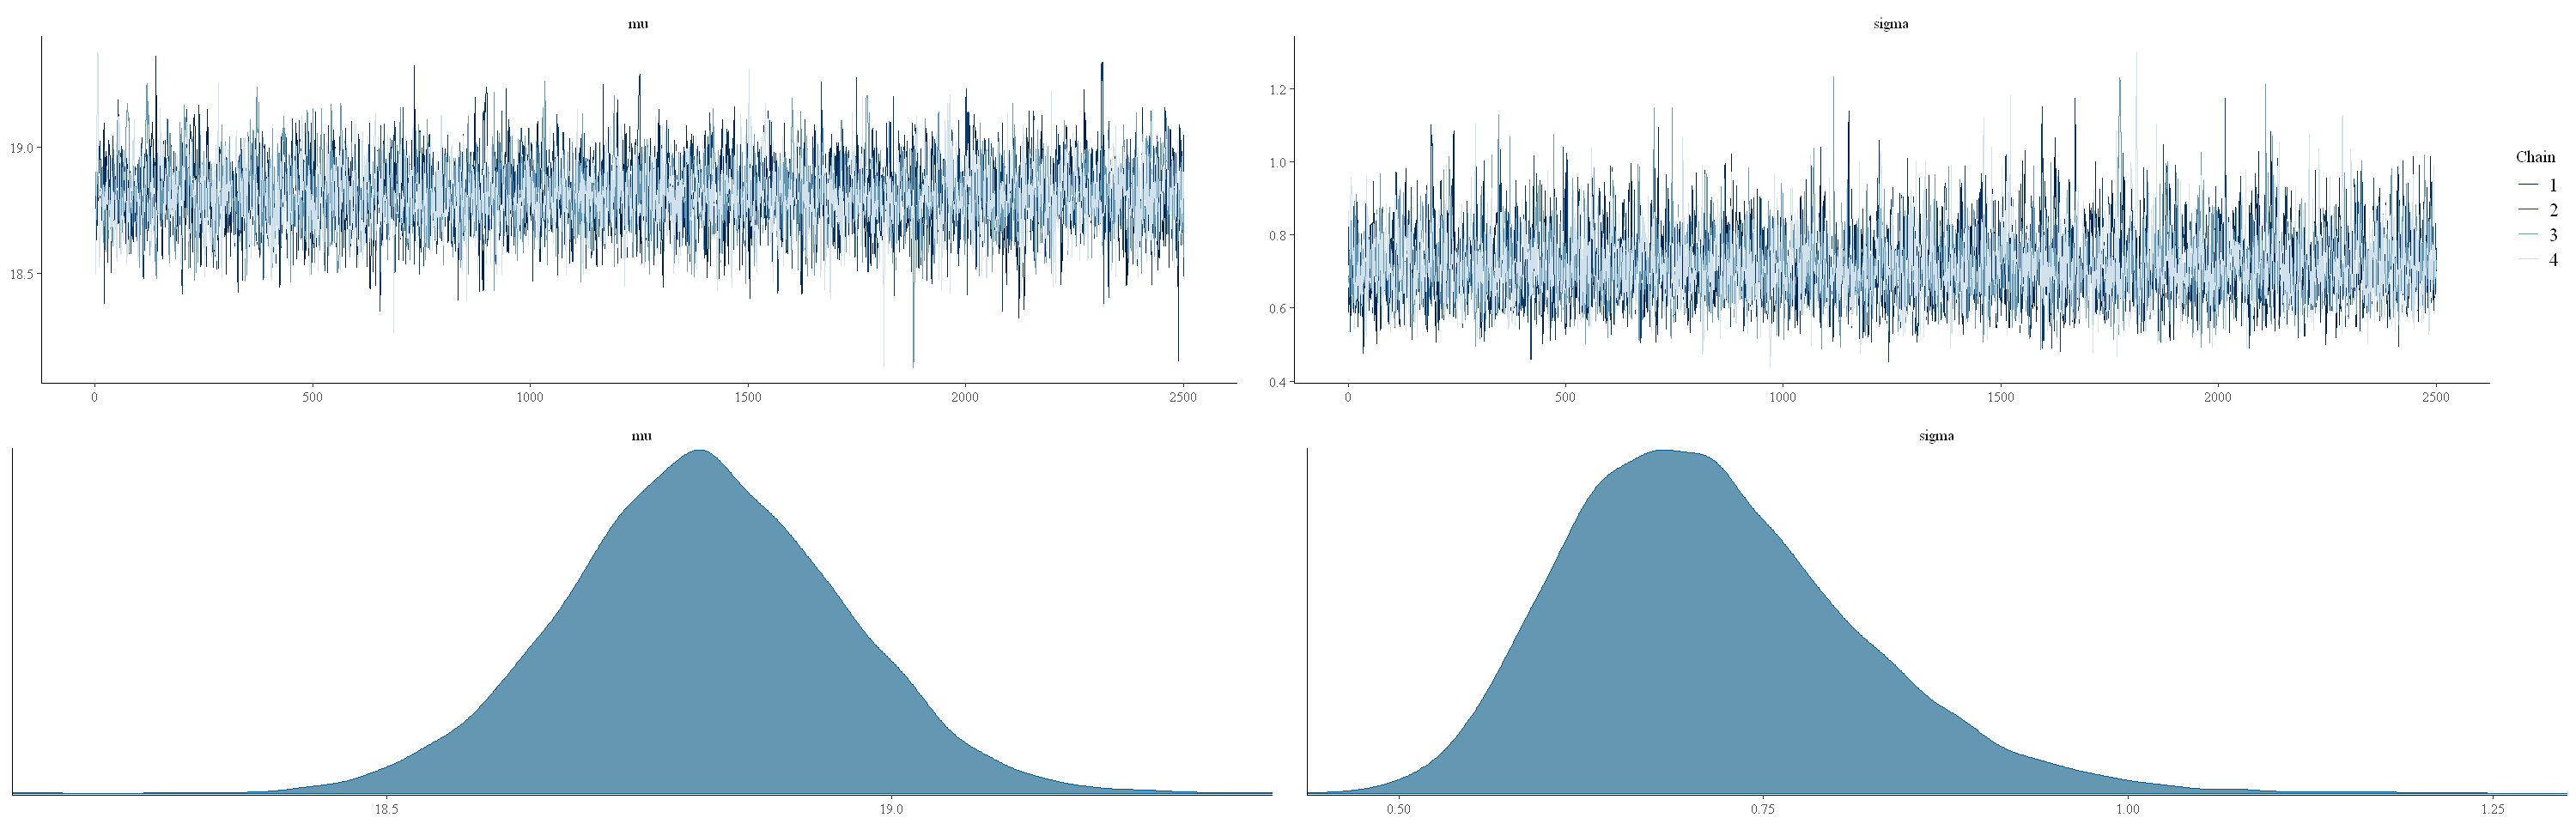

In [29]:
fit_constant <- run_bayesian_regression(station_dfs, "Porto_Tolle", "max", model_type = "constant")

**Interpretation of Model Fit Results**

We compared two Bayesian regression models to reproduce the annual maximum temperature data for the station **Porto_Tolle**.

**Linear Model Results**
- **Intercept ($\beta_0$)**: Mean = 18.81 °C
- **Slope ($\beta_1$)**: Mean = 0.06 °C/year  
  This indicates a slight positive warming trend over time (about +0.06 °C per year).
- **Sigma ($\sigma$)**: Mean = 0.53  


**Constant Model Results**
- **Mean Temperature ($\mu$)**: Mean = 18.81 °C
- **Sigma ($\sigma$)**: Mean = 0.71  


**Analysis**

The linear model yields **$\sigma$ = 0.53**, while the constant model has **$\sigma$ = 0.71**, showing that the linear model describes the temperature dynamics **more precisely**, capturing a trend over time rather than assuming no change.

Additionally, the positive slope (`beta_1`) reinforces it.


- **Perform a Bayesian hypothesis test comparing the two results**

For the hypothesis testing we will take the samples of the slope and checks how likely it is that the slope is different from zero, using Bayesian probability.

In [31]:
perform_bayes_test_slope <- function(fit_lin) {
  posterior <- extract(fit_lin)
  beta_1_samples <- posterior$beta_1
  
  prob_beta1_gt_0 <- mean(beta_1_samples > 0)
  prob_beta1_lt_0 <- mean(beta_1_samples < 0)
  
  cat(sprintf("P(beta_1 > 0) = %.3f\n", prob_beta1_gt_0))
  cat(sprintf("P(beta_1 < 0) = %.3f\n", prob_beta1_lt_0))
  
  # Bayesian hypothesis test decision
  if (prob_beta1_gt_0 > 0.975 || prob_beta1_lt_0 > 0.975) {
    cat("Supports linear model.\n")
  } else {
    cat("Constant Model.\n")
  }
}


In [33]:
perform_bayes_test_slope(fit_lin)

P(beta_1 > 0) = 1.000
P(beta_1 < 0) = 0.000
Supports linear model.


- **Do you see correlations between data measured at different stations?**

**Pearson Correlation**

We will calculate the **Pearson correlation coefficient** that quantifies the strength and direction of the **linear relationship** between two set of temperatures (corresponding to each station). 

$$ r = \frac{\mathrm{Cov}(X, Y)}{\sigma_X \sigma_Y} $$


The coefficient $r$ ranges from $-1$ to $+1$:
- $r = +1$: perfect positive linear relationship  
- $r = -1$: perfect negative linear relationship  
- $r = 0$: no linear correlation

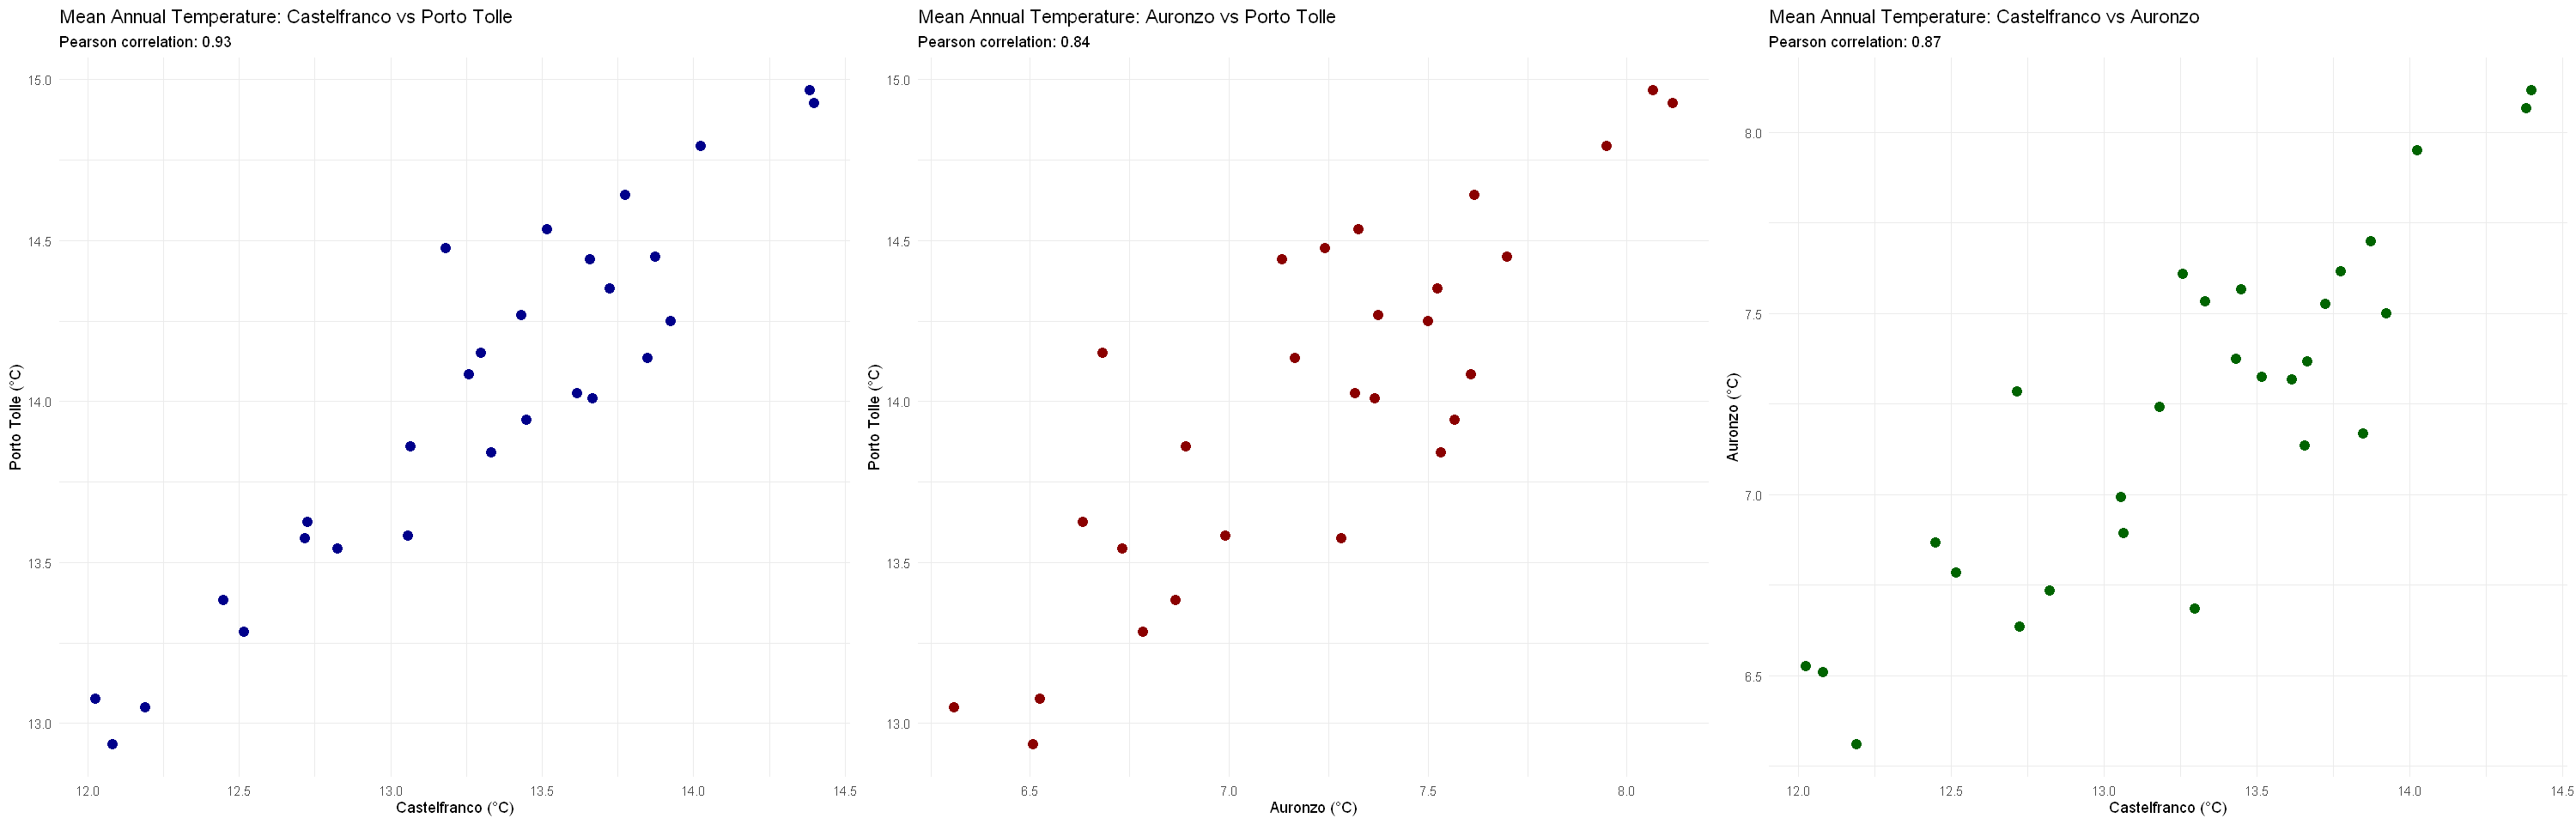

In [37]:
agg_station <- function(df, type = "medium") {
    # Aggregate annual temperatures for each station
    df %>%
    filter(Type == type) %>%  
    mutate(Year = as.numeric(Year),
           Temperature = as.numeric(Temperature)) %>%
    group_by(Year) %>%
    summarise(Annual_Temp = mean(Temperature, na.rm = TRUE), .groups = "drop")
}

castelfranco_agg <- agg_station(station_dfs$Castelfranco) %>% rename(Castelfranco = Annual_Temp)
porto_tolle_agg  <- agg_station(station_dfs$Porto_Tolle) %>% rename(Porto_Tolle = Annual_Temp)
auronzo_agg     <- agg_station(station_dfs$Auronzo) %>% rename(Auronzo = Annual_Temp)

# join pairs of stations to align their annual temperatures by year
df_joined_1 <- inner_join(castelfranco_agg, porto_tolle_agg, by = "Year")
df_joined_2 <- inner_join(auronzo_agg, porto_tolle_agg, by = "Year")
df_joined_3 <- inner_join(castelfranco_agg, auronzo_agg, by = "Year")

# Pearson correlations
cor_cast_porto <- cor(df_joined_1$Castelfranco, df_joined_1$Porto_Tolle, method = "pearson")
cor_auron_porto <- cor(df_joined_2$Auronzo, df_joined_2$Porto_Tolle, method = "pearson")
cor_cast_auron <- cor(df_joined_3$Castelfranco, df_joined_3$Auronzo, method = "pearson")

plot1 <- ggplot(df_joined_1, aes(x = Castelfranco, y = Porto_Tolle)) +
  geom_point(color = "darkblue", size = 3) +
  labs(
    title = "Mean Annual Temperature: Castelfranco vs Porto Tolle",
    subtitle = paste("Pearson correlation:", round(cor_cast_porto, 2)),
    x = "Castelfranco (°C)",
    y = "Porto Tolle (°C)"
  ) +
  theme_minimal()

plot2 <- ggplot(df_joined_2, aes(x = Auronzo, y = Porto_Tolle)) +
  geom_point(color = "darkred", size = 3) +
  labs(
    title = "Mean Annual Temperature: Auronzo vs Porto Tolle",
    subtitle = paste("Pearson correlation:", round(cor_auron_porto, 2)),
    x = "Auronzo (°C)",
    y = "Porto Tolle (°C)"
  ) +
  theme_minimal()

plot3 <- ggplot(df_joined_3, aes(x = Castelfranco, y = Auronzo)) +
  geom_point(color = "darkgreen", size = 3) +
  labs(
    title = "Mean Annual Temperature: Castelfranco vs Auronzo",
    subtitle = paste("Pearson correlation:", round(cor_cast_auron, 2)),
    x = "Castelfranco (°C)",
    y = "Auronzo (°C)"
  ) +
  theme_minimal()

grid.arrange(plot1, plot2, plot3, ncol = 3)

**Part 2**
- **Analysis of the evolution of the annual difference of the min, max and daily averate temperature over
time (1993 - 2021)**

In [39]:
# Easy to calculate now the mean temperature per year outside for filter later each 4 years
station_dfs <- map(station_dfs, ~ .x %>%
  mutate(
    Year = as.numeric(Year),
    Temperature = as.numeric(Temperature)
  ))


get_yearly_avg <- function(df) {
  df %>%
    group_by(Year, Type) %>%
    summarise(AnnualTemp = mean(Temperature, na.rm = TRUE), .groups = 'drop') %>%
    pivot_wider(names_from = Type, values_from = AnnualTemp) %>%
    rename(MIN_mean = min, MED_mean = medium, MAX_mean = max)
}

yearly_station_avg <- map(station_dfs, get_yearly_avg)


In [41]:
filtered_station_avg <- map(yearly_station_avg, function(df) {
  df %>%
    filter((Year - min(Year)) %% 4 == 0) %>%
    arrange(Year) %>%
    mutate(x_fit = 1:n())
})

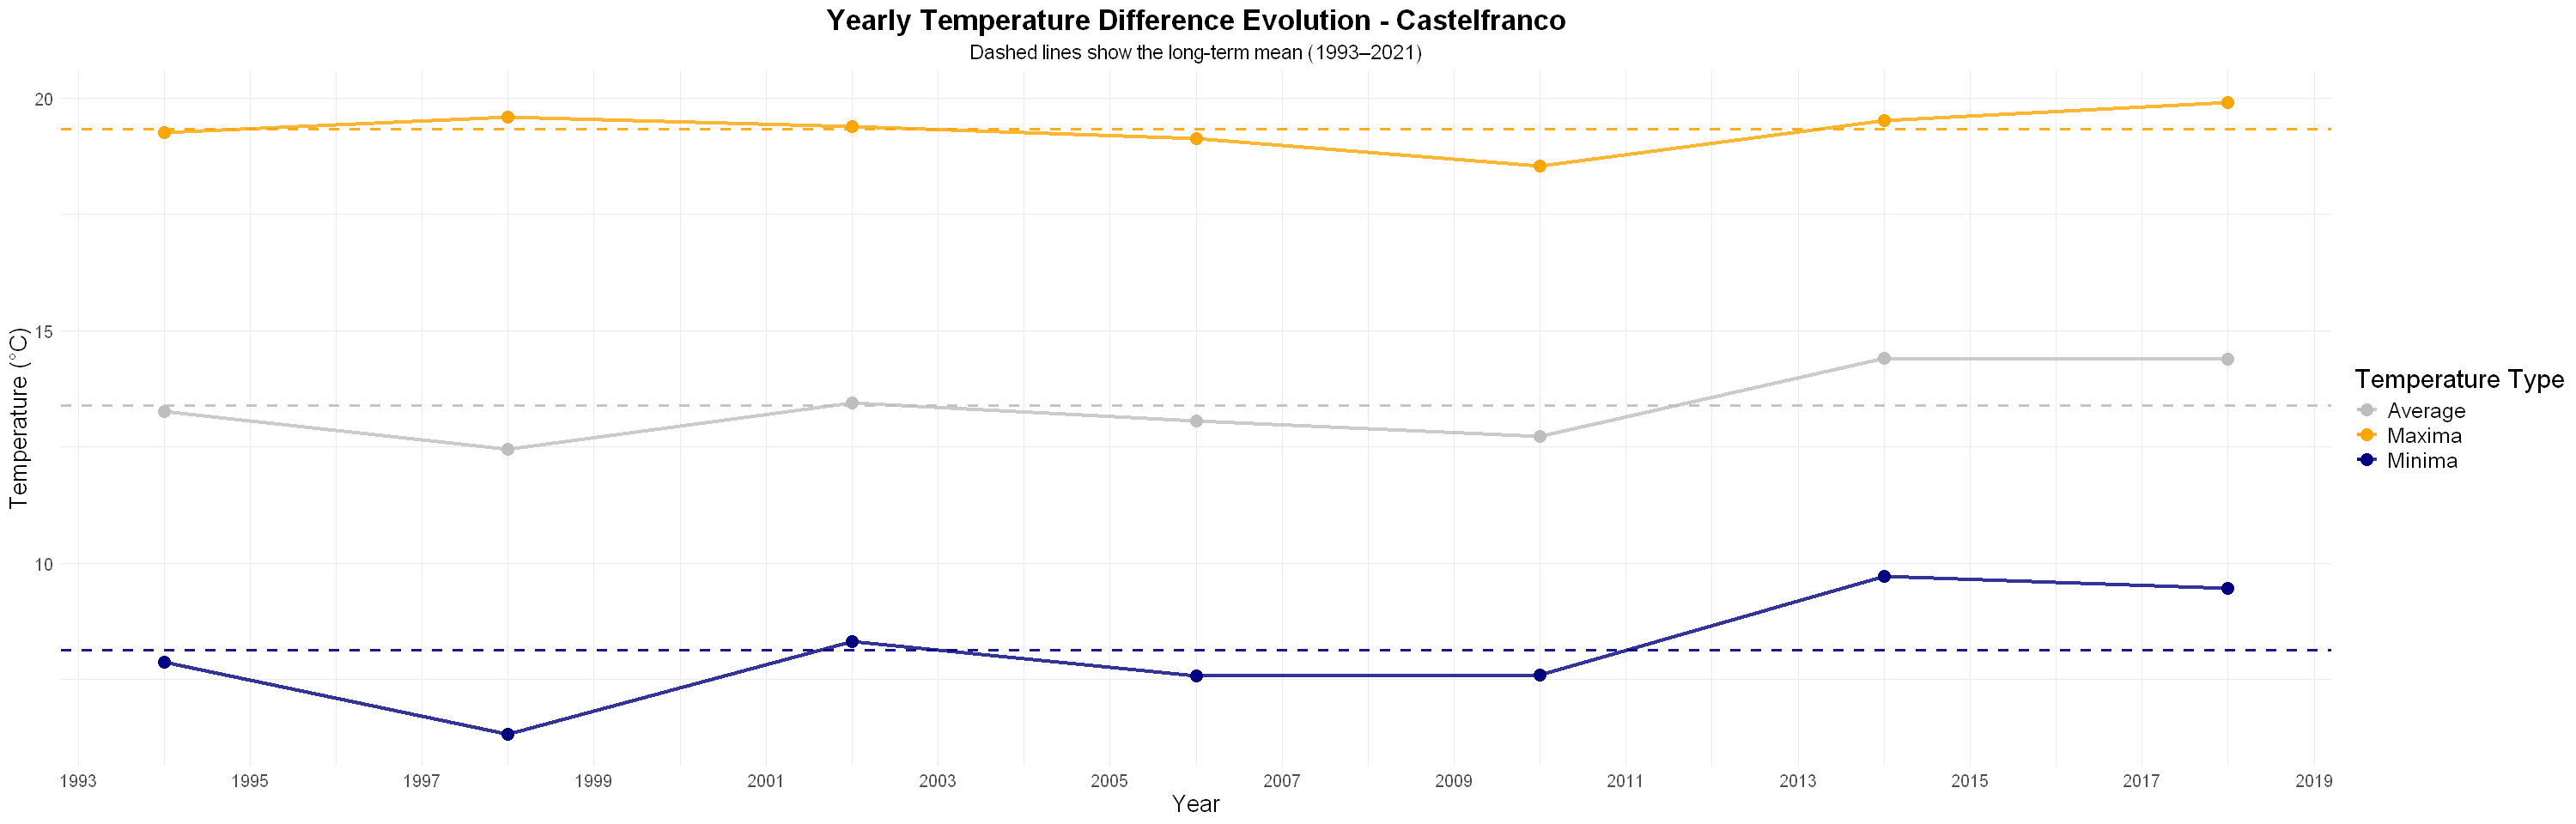

In [43]:
df <- filtered_station_avg$Castelfranco

ggplot(df) +

  geom_point(aes(x = Year, y = MED_mean, color = "Average"), size = 4) +
  geom_point(aes(x = Year, y = MIN_mean, color = "Minima"), size = 4) +
  geom_point(aes(x = Year, y = MAX_mean, color = "Maxima"), size = 4) +


  geom_line(aes(x = Year, y = MED_mean, color = "Average"), linewidth = 1.2, alpha = 0.8) +
  geom_line(aes(x = Year, y = MIN_mean, color = "Minima"), linewidth = 1.2, alpha = 0.8) +
  geom_line(aes(x = Year, y = MAX_mean, color = "Maxima"), linewidth = 1.2, alpha = 0.8) +


  geom_hline(aes(yintercept = mean(MED_mean), color = "Average"), linetype = "dashed", linewidth = 1, alpha = 0.9) +
  geom_hline(aes(yintercept = mean(MIN_mean), color = "Minima"), linetype = "dashed", linewidth = 1, alpha = 0.9) +
  geom_hline(aes(yintercept = mean(MAX_mean), color = "Maxima"), linetype = "dashed", linewidth = 1, alpha = 0.9) +

  scale_color_manual(
    name = "Temperature Type",
    values = c("Minima" = "navy", "Maxima" = "orange", "Average" = "gray")
  ) +
  labs(
    title = "Yearly Temperature Difference Evolution - Castelfranco",
    subtitle = "Dashed lines show the long-term mean (1993–2021)",
    x = "Year",
    y = "Temperature (°C)"
  ) +
  scale_x_continuous(breaks = seq(1993, 2021, by = 2)) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
    plot.subtitle = element_text(size = 14, hjust = 0.5),
    axis.title = element_text(size = 16),
    axis.text = element_text(size = 12),
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 15)
  )



• **Assuming you found an increasing trend in the temperature, compute it considering 4-years intervals and compare the results with those shown in SNPA (Sistema Nazionale per la Protezione Ambiente) in [1].**

$$
y = \alpha + \beta \cdot x + \varepsilon_t, \quad \varepsilon \sim \text{Normal}(0, 1.5)
$$

In [45]:
stan_model_code <- "
data {
  int<lower=0> N;           // data points
  vector[N] x;              // time steps
  vector[N] y;              // temperatures
}

parameters {
  real alpha;               // intercept
  real beta;                // slope
  real<lower=0> sigma;      // std deviation
}

model {
  sigma ~ normal(0, 1.5);                    // prior on sigma
  y ~ normal(alpha + beta * x, sigma);       // linear regression
}
"


In [47]:
types <- c("MIN_mean", "MED_mean", "MAX_mean")
fit_list <- list()
posterior_slopes <- list()

df <- df %>% mutate(x_fit_centered = scale(x_fit, scale = FALSE))

for (type in types) {
  y <- df[[type]]
  stan_data <- list(N = nrow(df), x = as.vector(df$x_fit_centered), y = y)
  
  fit <- stan(model_code = stan_model_code,
              data = stan_data,
              iter = 5000,
              chains = 4,
              seed = 123,
              control = list(adapt_delta = 0.95))
  
  fit_list[[type]] <- fit
  posterior_slopes[[type]] <- extract(fit)$beta
}


In [48]:
posterior_df <- purrr::imap_dfr(posterior_slopes, ~ {
  short_type <- gsub("_mean", "", .y)  
  data.frame(slope_10yr = .x * 2.5, type = short_type)
})

theoretical <- data.frame(
  type = c("MIN", "MED", "MAX"),
  mean = c(0.34, 0.38, 0.42),
  sd = c(0.04, 0.05, 0.06)
)
# Add 95% credible intervals to compare with the theoretical value
posterior_summary <- posterior_df %>%
  group_by(type) %>%
  summarise(
    mean = mean(slope_10yr),
    lower = quantile(slope_10yr, 0.025),
    upper = quantile(slope_10yr, 0.975)
  ) %>%
  left_join(theoretical, by = "type", suffix = c("_post", "_theo"))


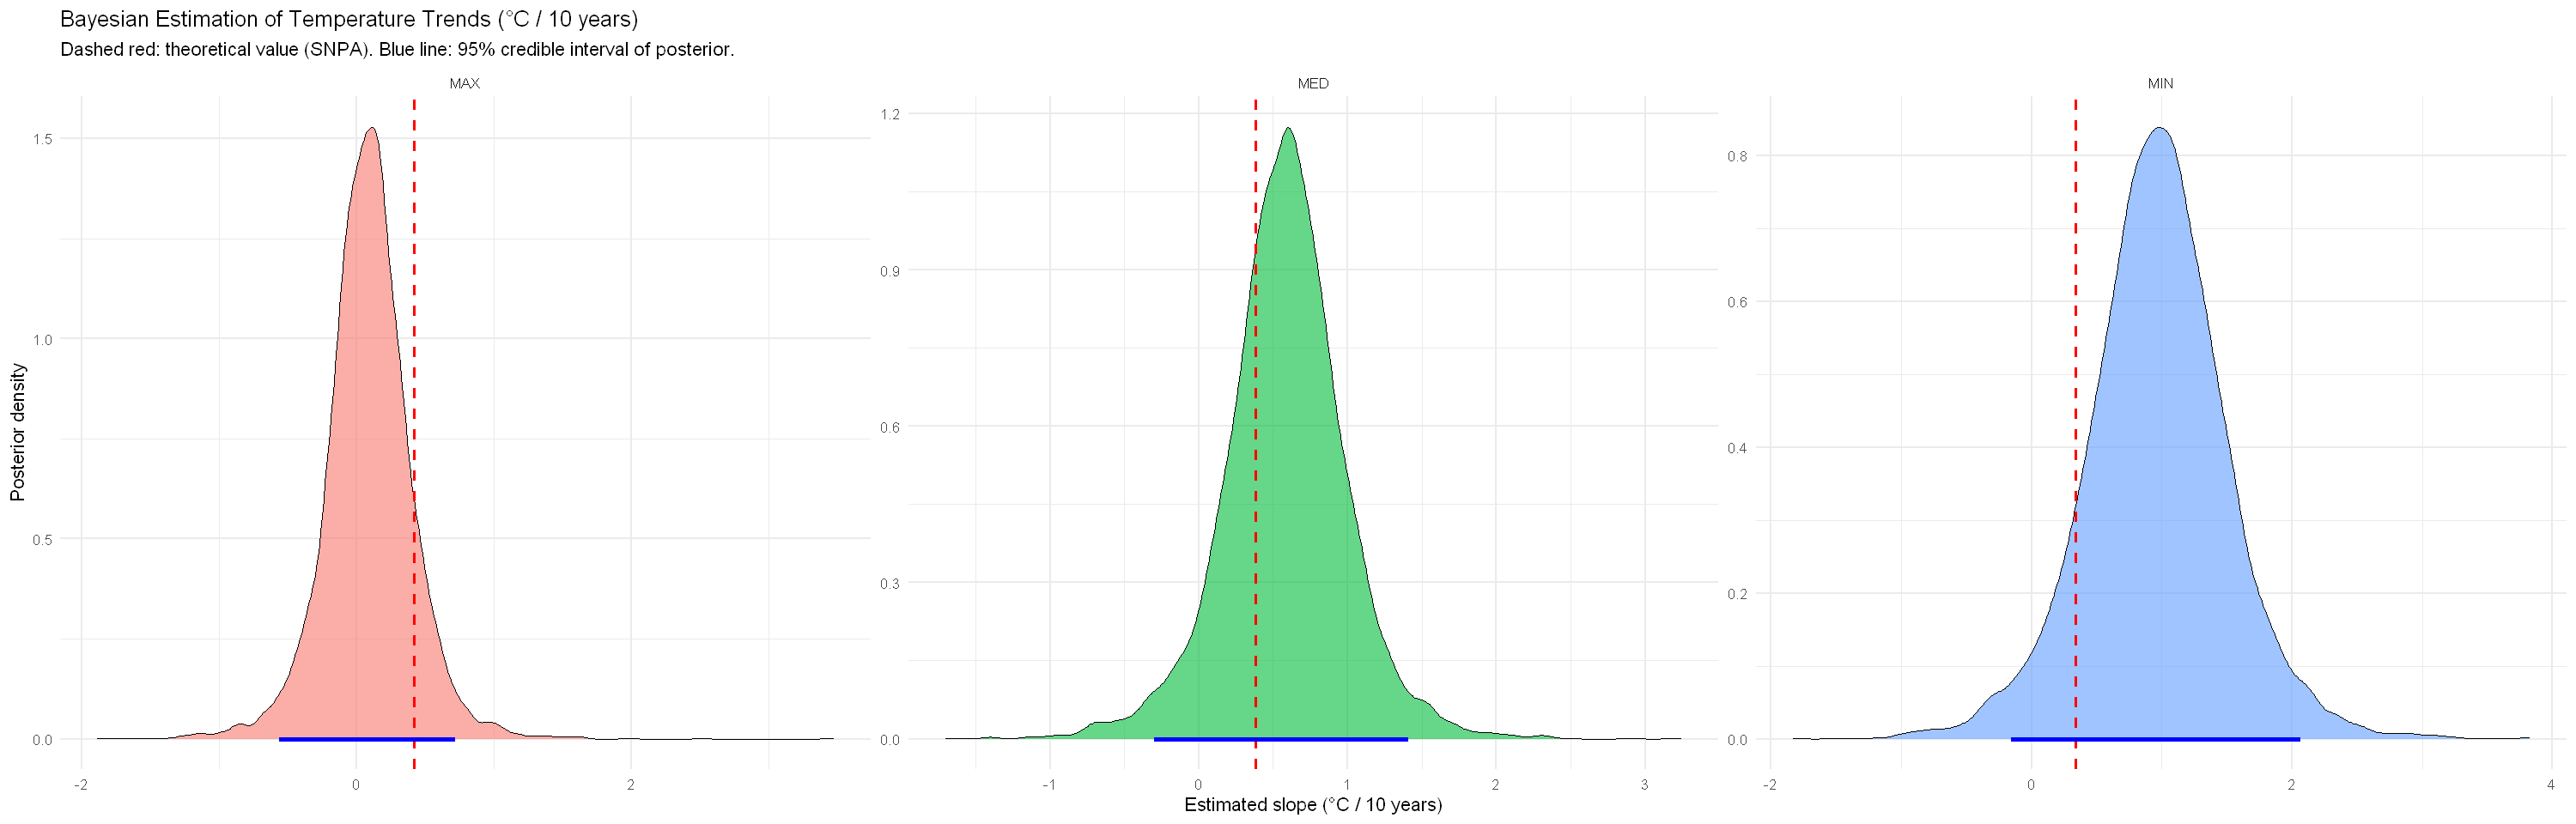

In [50]:
ggplot(posterior_df, aes(x = slope_10yr, fill = type)) +
  geom_density(alpha = 0.6, color = "black") +
  geom_vline(data = theoretical, aes(xintercept = mean), 
             linetype = "dashed", color = "red", linewidth = 1) +
  geom_segment(data = posterior_summary,
               aes(x = lower, xend = upper, y = 0, yend = 0),
               color = "blue", linewidth = 1.5) +
  facet_wrap(~type, scales = "free") +
  labs(
    title = "Bayesian Estimation of Temperature Trends (°C / 10 years)",
    subtitle = "Dashed red: theoretical value (SNPA). Blue line: 95% credible interval of posterior.",
    x = "Estimated slope (°C / 10 years)",
    y = "Posterior density"
  ) +
  theme_minimal(base_size = 13) +
  theme(legend.position = "none")

**Part 3**
Using the forecast R package [2], which provides methods and tools for displaying and analysing univariate
time series, analyze the data. The library contains also the ARIMA (Autoregressive Integrated
Moving Average), which allows to perform the equivalent of a linear regression in time series, where data
is not stationary. Analyze your data and try to predict the evolution in the next years (average the data
over multiple years, if needed).

**Stationary Time Series**

A **stationary** time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are **not stationary** — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

In general, a stationary time series will have no predictable patterns in the long-term.

![Annual Temperature Plot](Annual_Temperature_Castelfranco.png)

We analyze the time evolution of the data for determine if our data serie is stationary or no-stationary, in this way we can determine the parameter $d$ of the Arima model (order of the differentitation).

Data seems stationary (the mean is pretty stable even if rising) we don't probably need to do a second order differentitation, with $d=1$ should be necessary for converting the non-stationary tendency into a stationarity one.

**Differencing**

One way to make a non-stationary time series stationary — compute the differences between consecutive observations. This is known as differencing.

Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

As well as looking at the time plot of the data, the ACF plot is also useful for identifying non-stationary time series. For a stationary time series, the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly.

**Non-Seasonal ARIMA Models**

If we combine **differencing** with **autoregression** and a **moving average model**, we obtain a **non-seasonal ARIMA model**.  
ARIMA stands for **AutoRegressive Integrated Moving Average** (where "integration" refers to reversing differencing).

The full model can be written as:

$$
y'_t = c + \phi_1 y'_{t-1} + \cdots + \phi_p y'_{t-p} + \theta_1 \varepsilon_{t-1} + \cdots + \theta_q \varepsilon_{t-q} + \varepsilon_t
\tag{8.1}
$$

where $y'_t$ is the **differenced series** (possibly differenced more than once). The predictors on the right-hand side include both **lagged values of $y_t$** and **lagged forecast errors**.  

We call this an **ARIMA($p$, $d$, $q$)** model, where:

- $p$ = order of the autoregressive (AR) part  
- $d$ = degree of differencing  
- $q$ = order of the moving apo **A models.

---

### Speci**al Cases of ARIMA Models

| Model Description          | ARIMA Form        |
|---------------------------|-------------------|
| White noise               | ARIMA(0, 0, 0)    |
| Random walk               | ARIMA(0, 1, 0) without constant |
| Random walk with drift    | ARIMA(0, 1, 0) with constant |
| Autoregressive model      | ARIMA($p$, 0, 0)  |
| Moving average model      | ARIMA(0, 0, $q$)  |


## Understanding ARIMA Models

The `auto.arima()` function is useful, but anything automated can be a little dangerous. It's worth understanding the behavior of ARIMA models, even when relying on automatic procedures to select them.



## ACF and PACF Plots

It is usually not possible to determine, simply from a time plot, what values of $p$ and $q$ are appropriate for the data. However, it is sometimes possible to use the **Autocorrelation Function (ACF)** plot, and the closely related **Partial Autocorrelation Function (PACF)** plot, to help identify suitable values for $p$ and $q$.

The **ACF plot** displays autocorrelations, which measure the relationship between $y_t$ and $y_{t-k}$ for different values of $k$. For example, if $y_t$ and $y_{t-1}$ are correlated, then $y_{t-1}$ and $y_{t-2}$ must also be correlated. In that case, $y_t$ and $y_{t-2}$ may appear to be correlated simply because they are both related to $y_{t-1}$, rather than due to new information in $y_{t-2}$ that helps forecast $y_t$.

To overcome this issue, we use **partial autocorrelations**, which measure the direct relationship between $y_t$ and $y_{t-k}$ after removing the effects of intermediate lags ($1, 2, 3, \dots, k-1$). The first partial autocorrelation is identical to the first autocorrelation, since there is no lag in between to adjust for.

Each partial autocorrelation can be estimated as the last coefficient in an autoregressive model. Specifically, $\alpha_k$, the $k$th partial autocorrelation coefficient, is equal to the estimate of $\phi_k$ in an AR($k$) model. In practice, more efficient algorithms are used to compute $\alpha_k$ without fitting multiple autoregressions, but the resultsivalent.


In [52]:
get_yearly_avg_ts <- function(station_name, temp_type) {
  station_dfs[[station_name]] %>%
    filter(Type == temp_type) %>%
    mutate(Temperature = as.numeric(gsub(",", ".", Temperature))) %>%
    group_by(Year) %>%
    summarise(YearlyAvg = mean(Temperature, na.rm = TRUE)) %>%
    pull(YearlyAvg) %>%
    ts(start = min(station_dfs[[station_name]]$Year))
}



In [54]:
ts_data <- get_yearly_avg_ts("Castelfranco", "medium")

In [56]:
ACFPlots <- function(ts_data, type) {
  options(repr.plot.width = 18, repr.plot.height = 6)
  
  acf <- ggAcf(ts_data, lag = length(ts_data)) +
    labs(title = paste('ACF plot for the yearly', type, 'temperatures')) +
    theme_bw() +
    theme(plot.title = element_text(size = 22, hjust = 0.5),
          axis.title = element_text(size = 18),
          legend.text = element_text(size = 15),
          legend.title = element_text(size = 17))
  
  pacf <- ggPacf(ts_data, lag = length(ts_data)) +
    labs(title = paste('PACF plot for the yearly', type, 'temperatures')) +
    theme_bw() +
    theme(plot.title = element_text(size = 22, hjust = 0.5),
          axis.title = element_text(size = 18),
          legend.text = element_text(size = 15),
          legend.title = element_text(size = 17))
  
  grid.arrange(acf, pacf, ncol = 2)
}

**Interpreting ACF and PACF Plots in ARIMA Modelling**

The **partial autocorrelations** have the same critical values as ordinary autocorrelations:

$$
\pm \frac{1.96}{\sqrt{T}}
$$

where $T$ is the sample size.

---

If the data follow an **ARIMA($p$, $d$, 0)** or **ARIMA(0, $d$, $q$)** model, the **ACF** and **PACF** plots of the differenced data can help in selecting values of $p a**q$.

---

### Signs of **ARIMA($p$, $d$, 0)

If the differenced data suggest an ARIMA($p$, $d$, 0) model:

- The **ACF** is **exponentially decaying** or **sinusoidal**.
- The **PACF** has a **significant spike at lag $p$**, with no significant spikes**ond lag $p$.

---

### **Signs of ARIMA(0, $d$, $q$)

If the differenced data suggest an ARIMA(0, $d$, $q$) model:

- The **PACF** is **exponentially decaying** or **sinusoidal**.
- The **ACF** has a **significant spike at lag $q$**, with no significant spikes beyond lag $q$.


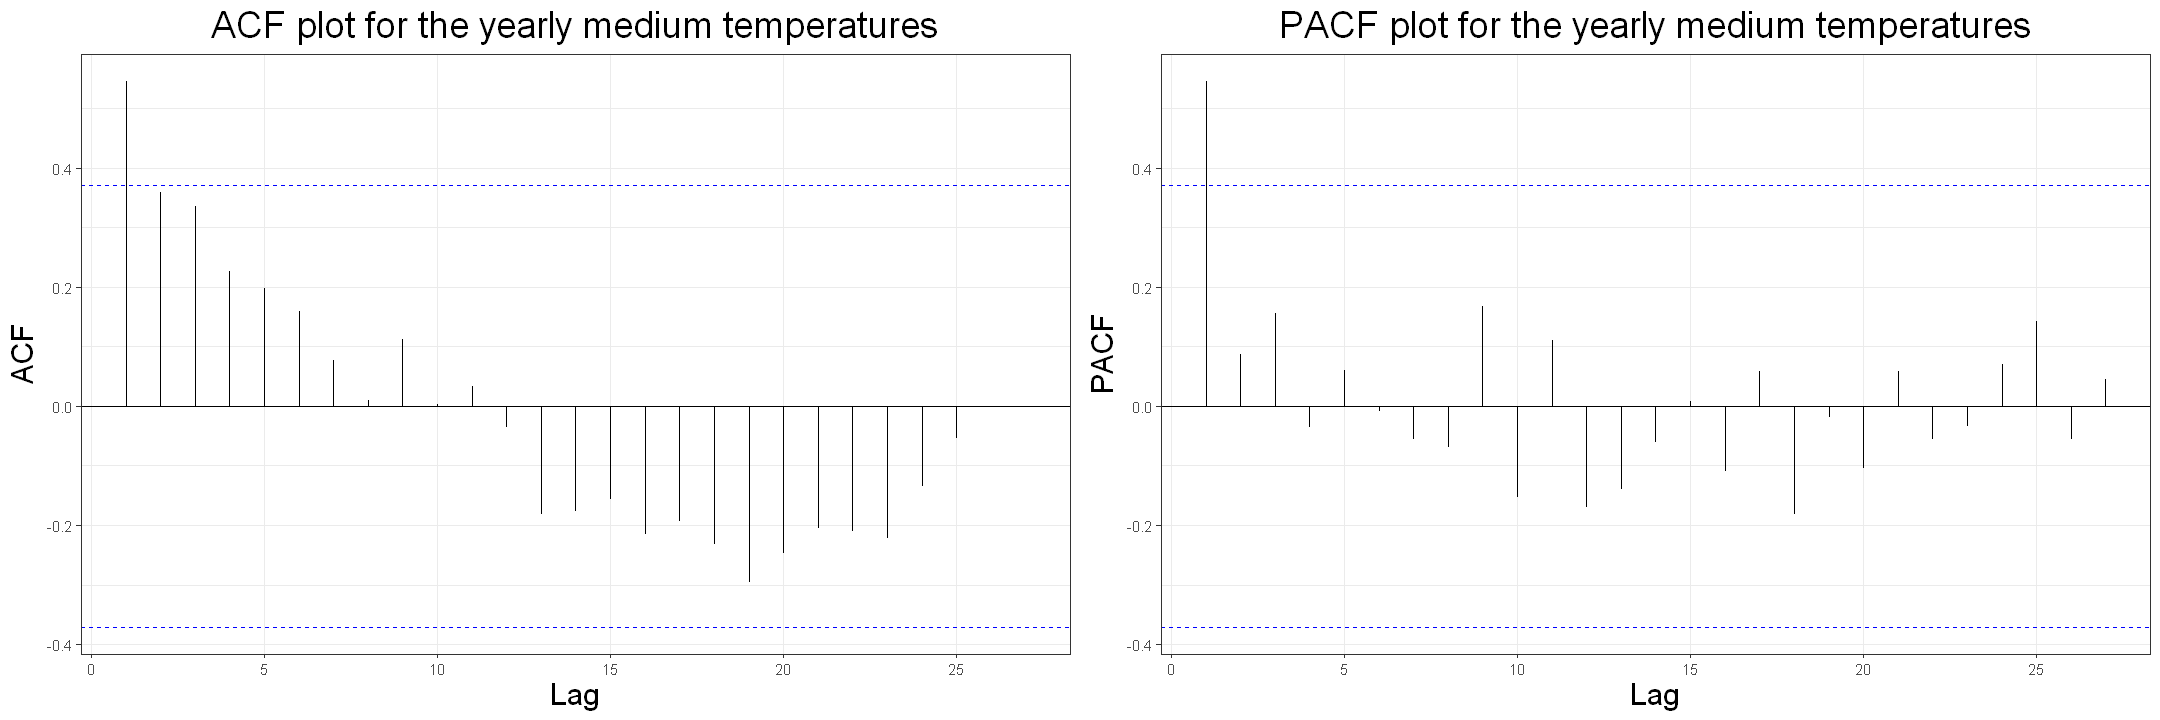

In [58]:
ACFPlots(ts_data, "medium")

This analysis could be a litle confusing because we can think that observing the ACF and PACF the best model can correspond to $ ARIMA(1, 1, 0)$ or $ ARIMA(0, 1, 1)$, our reasons are:

We see sign of an ARIMA($p = 1$, $d = 1$, 0), because:
- The **ACF** is **sinusoidal**.
- The **PACF** has a **significant spike at lag $p = 1$**, with no significant spikes beyond lag $p = 1$.

But, we also see sign of an ARIMA($0$, $d = 1$, $q=1$), because:
- The **PACF** is **exponentially decaying**.
- The **ACF** has a **significant spike at lag $q = 1$**, with no significant spikes beyond lag $q$ (because they are below the threshold).

So at first we would try these two fits without the `auto.arima()` function to gain intuition.

In [60]:
fit1 <- Arima(ts_data, order=c(1,1,0))
summary(fit1)

Series: ts_data 
ARIMA(1,1,0) 

Coefficients:
          ar1
      -0.3382
s.e.   0.1927

sigma^2 = 0.3595:  log likelihood = -24.05
AIC=52.1   AICc=52.6   BIC=54.69

Training set error measures:
                     ME      RMSE     MAE         MPE     MAPE      MASE
Training set 0.01067611 0.5777464 0.47328 -0.04093378 3.587507 0.9025469
                    ACF1
Training set -0.07767028

In [62]:
fit2 <- Arima(ts_data, order=c(0,1,1))
summary(fit2)

Series: ts_data 
ARIMA(0,1,1) 

Coefficients:
          ma1
      -0.6649
s.e.   0.1476

sigma^2 = 0.3039:  log likelihood = -22.02
AIC=48.03   AICc=48.53   BIC=50.62

Training set error measures:
                     ME     RMSE       MAE       MPE     MAPE      MASE
Training set 0.08395757 0.531255 0.4339656 0.4989992 3.281965 0.8275742
                   ACF1
Training set 0.08192611

Looking at the AICc, which is the most accurate value for comparing the model we see that the best option a priori is $ ARIMA(0, 1, 1)$

**Maximum Likelihood Estimation**

Once the model order has been identified (i.e., the values of $p$, $d$, and $q$), we need to estimate the parameters $c$, $\phi_1, \dots, \phi_p$, and $\theta_1, \dots, \theta_q$. When R estimates the ARIMA model, it uses **maximum likelihood estimation (MLE)**. This technique finds the values of the parameters which **maximize the probability** of observing the given data.

In practice, R reports the **log-likelihood** of the data—that is, the logarithm of the probability of the observed data under the estimated model. For given values of $p$, $d$, and $q$, R maximizes the log-likelihood to find the best parameter estimates.



**Information Criteria**

**Akaike’s Information Criterion (AIC)**, also useful in regression, helps determine the order of an ARIMA model:

$$
\text{AIC} = -2\log(L) + 2(p + q + k + 1)
$$

- $L$ = likelihood of the data  
- $k = 1$ if $c \ne 0$, and $k = 0$ if $c = 0$  
- The term $(p + q + k + 1)$ represents the total number of parameters, including the residual variance $\sigma^2$

The **corrected AIC (AICc)** is:

$$
\text{AICc} = \text{AIC} + \frac{2(p + q + k + 1)(p + q + k + 2)}{T - p - q - k - 2}
$$

The **Bayesian Information Criterion (BIC)** is:

$$
\text{BIC} = \text{AIC} + [\log(T) - 2](p + q + k + 1)
$$

Good models are selected by **minimizing** AIC, AICc, or BIC. In general, **AICc** is preferred.

1. Choose $d$ using other methods (e.g., examining stationarity).
2. Then use AICc to select $p$ and $q$.


## 8.7 ARIMA Modelling in R

### How does `auto.arima()` worodelling

1. **Determine the number of differences** ($0 \le d \le 2$) using repeated **KPSS tests**.

2. **Select $p$ and $q$** by minimizing the **AICc** after differencing the data $d$ times.  
   Instead of searching all possible combinations, a **stepwise search** is used.

   a. **Fit four initial models**:
      - ARIMA($0$, $d$, $0$)  
      - ARIMA($2$, $d$, $2$)  
      - ARIMA($1$, $d$, $0$)  
      - ARIMA($0$, $d$, $1$)

   b. A **constant is included** unless $d = 2$.  
      If $d \le 1$, also fit:
      - ARIMA($0$, $d$, $0$) **without a constant**

   c. The model with the **smallest AICc** from step (a) becomes the **current model**.

   d. **Explore variations** around the current model:
      - Adjust $p$ and/or $q$ by $\pm 1$  
      - Include or exclude constant $c$

   e. Update the current model to the best among all considered.

   f. **Repeat step 2(d)** until no mfound.

---

### Additional Notes

- By default, some **approximations** are used to speed up the search. You can disable them with `approximation = FALSE`.
- It's possible that the true **minimum-AICc** model might not be found due to approximations or stepwise limitations.
- For a more **exhaustive search**, set `stepwise = FALSE`.
- See the help file (`?auto.arima`) for full argument documentation.


In [64]:
auto_fit <- auto.arima(ts_data, stepwise=FALSE, approximation=FALSE)

summary(auto_fit)

Series: ts_data 
ARIMA(0,1,1) 

Coefficients:
          ma1
      -0.6649
s.e.   0.1476

sigma^2 = 0.3039:  log likelihood = -22.02
AIC=48.03   AICc=48.53   BIC=50.62

Training set error measures:
                     ME     RMSE       MAE       MPE     MAPE      MASE
Training set 0.08395757 0.531255 0.4339656 0.4989992 3.281965 0.8275742
                   ACF1
Training set 0.08192611

We obtained a coherent result since the `auto.arima()` support our previous results.

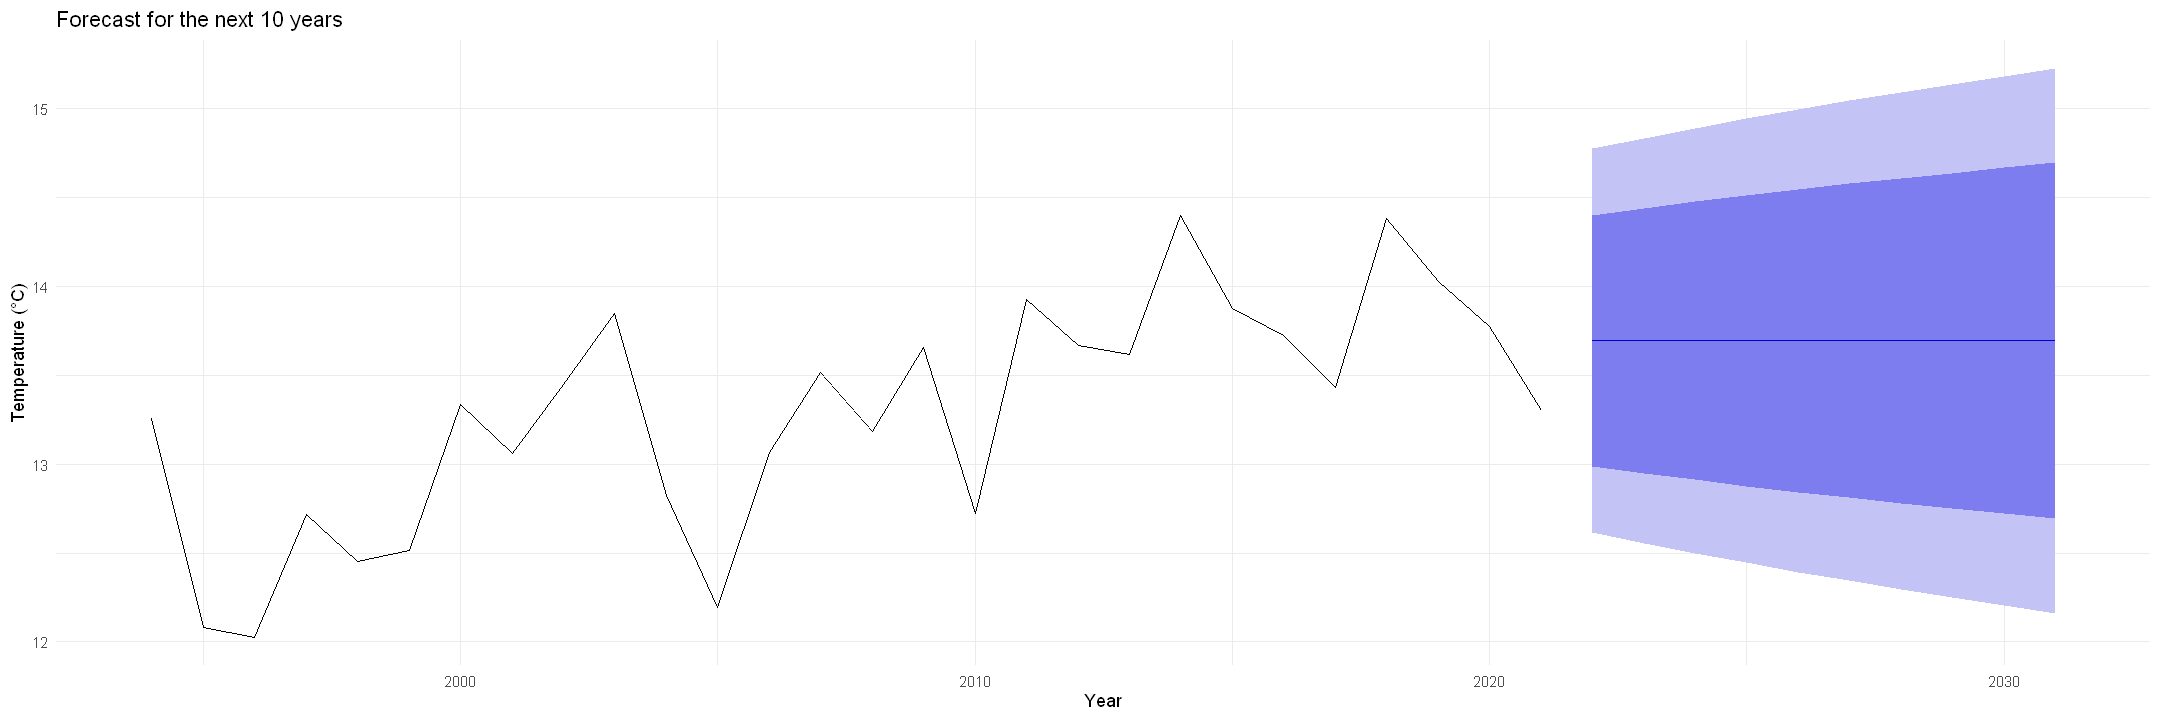

In [66]:
forecast <- forecast(auto_fit, h = 10)

# Plot forecast
autoplot(forecast) +
  labs(title = "Forecast for the next 10 years",
       x = "Year", y = "Temperature (°C)") +
  theme_minimal()


	Ljung-Box test

data:  Residuals from ARIMA(0,1,1)
Q* = 1.5386, df = 5, p-value = 0.9086

Model df: 1.   Total lags used: 6



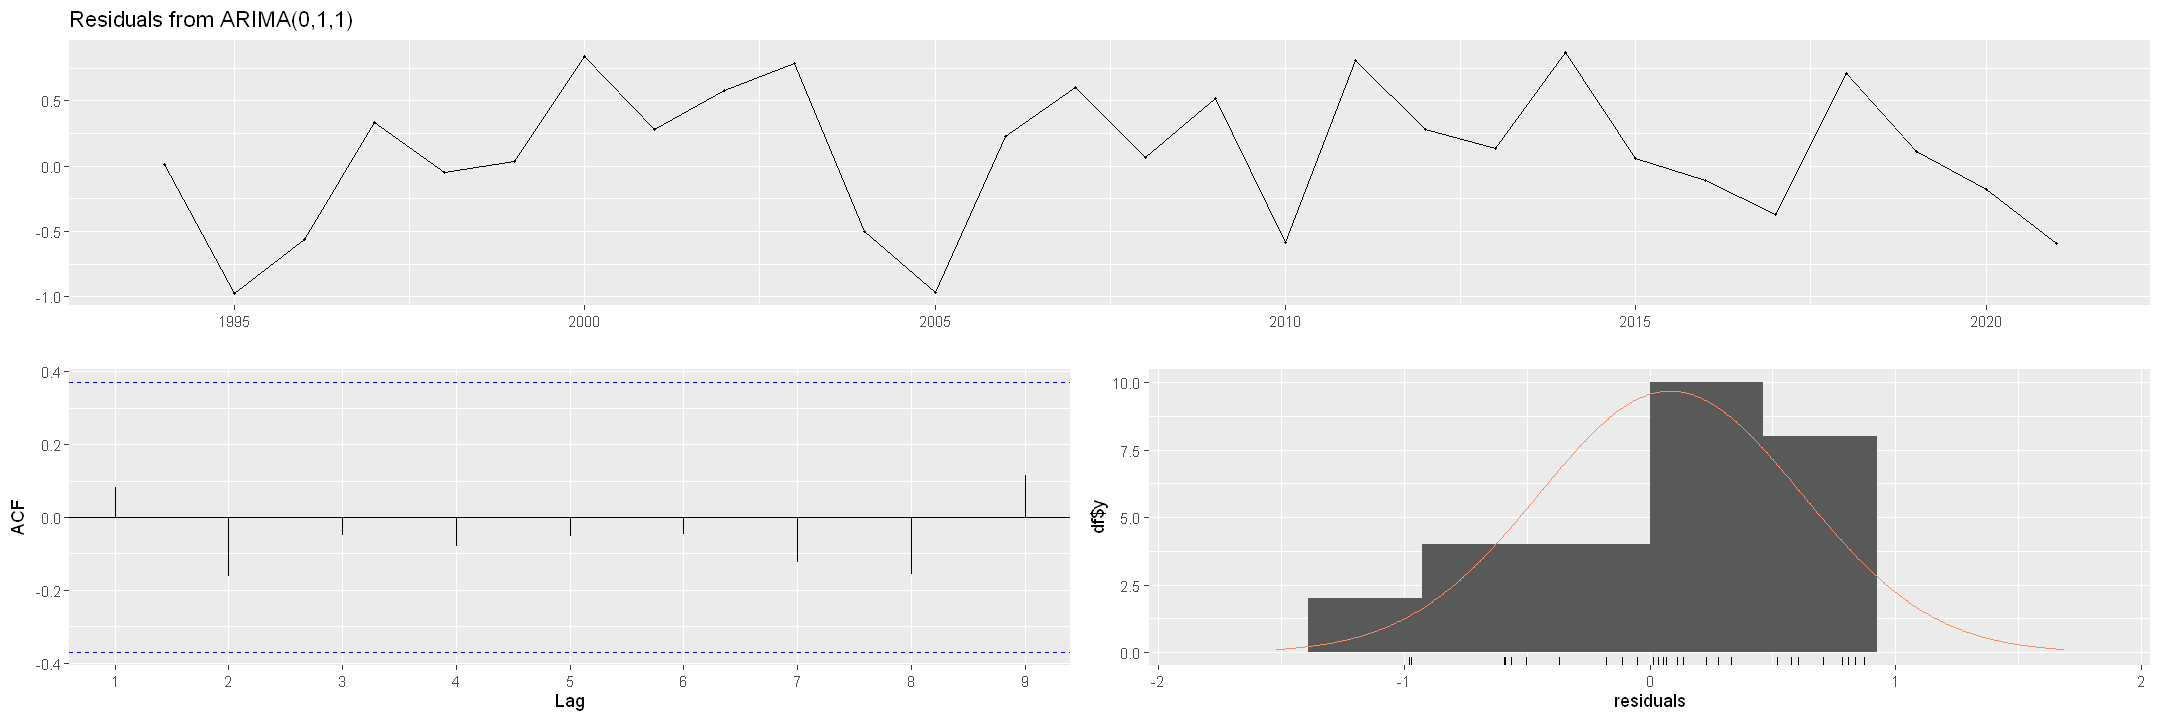

In [68]:
checkresiduals(forecast, plot = TRUE)

All the residuals fall clearly inside the white noise window so the model is well fitting.